In [1]:
from tensorflow_model_optimization.python.core.sparsity.keras import pruning_wrapper
from sklearn.metrics import accuracy_score
from tensorflow import keras
from sklearn import metrics
import tensorflow as tf
import pandas as pd
import numpy as np
import plotting
import hls4ml
import shap
import sys
import os

np.random.seed(77)

import matplotlib.pyplot as plt
import mplhep
plt.style.use(mplhep.style.CMS)

/grid_mnt/vol_home/llr/cms/motta/Phase2L1T/CMSSW_12_3_0_pre4/src/L1TauMinator/L1TauMinatorSoftware/TauMinator_hls4ml/hls4ml_instruct_cnn/hls4ml/converters/__init__.py:15: UserWarning: WARNING: Pytorch converter is not enabled!
  warnings.warn("WARNING: Pytorch converter is not enabled!")


In [2]:
options = {
    'v'          : '9',
    'date'       : '2022_09_14',
    'inTagIdent' : '_lTauPtCut18',
    'inTagCalib' : '_lTauPtCut18_uEtacut1.5',
    'caloClNxM'  : '5x9'
}

In [3]:
indir = '/data_CMS/cms/motta/Phase2L1T/'+options['date']+'_v'+options['v']

N = int(options['caloClNxM'].split('x')[0])
M = int(options['caloClNxM'].split('x')[1])

In [4]:
X1_id = np.load(indir+'/TauCNNIdentifier'+options['caloClNxM']+'Training'+options['inTagIdent']+'/X_CNN_'+options['caloClNxM']+'_forEvaluator.npz')['arr_0']
X2_id = np.load(indir+'/TauCNNIdentifier'+options['caloClNxM']+'Training'+options['inTagIdent']+'/X_Dense_'+options['caloClNxM']+'_forEvaluator.npz')['arr_0']
Y_id  = np.load(indir+'/TauCNNIdentifier'+options['caloClNxM']+'Training'+options['inTagIdent']+'/Y_'+options['caloClNxM']+'_forEvaluator.npz')['arr_0']

X1_id = np.float32(X1_id)
X2_id = np.float32(X2_id)
Y_id = np.float32(Y_id)

X1_id_reduced = X1_id[:3000]
X2_id_reduced = X2_id[:3000]
Y_id_reduced = Y_id[:3000]

In [5]:
X1_cal = np.load(indir+'/TauCNNCalibrator'+options['caloClNxM']+'Training'+options['inTagCalib']+'/X_CNN_'+options['caloClNxM']+'_forEvaluator.npz')['arr_0']
X2_cal = np.load(indir+'/TauCNNCalibrator'+options['caloClNxM']+'Training'+options['inTagCalib']+'/X_Dense_'+options['caloClNxM']+'_forEvaluator.npz')['arr_0']
Y_cal  = np.load(indir+'/TauCNNCalibrator'+options['caloClNxM']+'Training'+options['inTagCalib']+'/Y_'+options['caloClNxM']+'_forEvaluator.npz')['arr_0']

X1_cal = np.float32(X1_cal)
X2_cal = np.float32(X2_cal)
Y_cal = np.float32(Y_cal)

X1_cal_reduced = X1_cal[:3000]
X2_cal_reduced = X2_cal[:3000]
Y_cal_reduced = Y_cal[:3000]

In [6]:
CNN = keras.models.load_model(indir+'/TauCNNIdentifier'+options['caloClNxM']+'Training'+options['inTagIdent']+'/CNNmodel', compile=False)
QCNN = keras.models.load_model(indir+'/TauCNNIdentifier'+options['caloClNxM']+'Training'+options['inTagIdent']+'/QCNNmodel', compile=False)

DNNident = keras.models.load_model(indir+'/TauCNNIdentifier'+options['caloClNxM']+'Training'+options['inTagIdent']+'/DNNmodel', compile=False)
QDNNident = keras.models.load_model(indir+'/TauCNNIdentifier'+options['caloClNxM']+'Training'+options['inTagIdent']+'/QDNNmodel', compile=False)

DNNcalib = keras.models.load_model(indir+'/TauCNNCalibrator'+options['caloClNxM']+'Training'+options['inTagCalib']+'/TauCNNCalibrator', compile=False)
QDNNcalib = keras.models.load_model(indir+'/TauCNNCalibrator'+options['caloClNxM']+'Training'+options['inTagCalib']+'/TauCNNQCalibrator', compile=False)

2022-09-25 10:01:36.746307: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /grid_mnt/opt__exp_soft/llr/python/3.9.9/lib/python3.9/site-packages/cv2/../../lib64:/opt/exp_soft/llr/python/3.9.9/lib/vtk:/opt/exp_soft/llr/python/3.9.9/lib:/usr/lib64/classads:/usr/lib64:/usr/lib
2022-09-25 10:01:36.746356: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2022-09-25 10:01:36.746840: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) t

# NON-QUANTIZED MODELS FIRST

## Create HLS model for the identification CNN and DNN - NON-QUANTIZED

Interpreting Model
Topology:
Layer name: TowerClusterImage, layer type: Input
Layer name: CNNlayer1, layer type: Conv2D
  -> Activation (linear), layer name: CNNlayer1
Layer name: BN_CNNlayer1, layer type: BatchNormalization
Layer name: RELU_CNNlayer1, layer type: Activation
Layer name: MP_CNNlayer1, layer type: MaxPooling2D
Layer name: CNNlayer2, layer type: Conv2D
  -> Activation (linear), layer name: CNNlayer2
Layer name: BN_CNNlayer2, layer type: BatchNormalization
Layer name: RELU_CNNlayer2, layer type: Activation
Layer name: TowerClusterPosition, layer type: Input
Layer name: middleMan, layer type: Concatenate
{'Model': {'Precision': 'ap_fixed<19,7>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'TowerClusterImage': {'Precision': 'ap_fixed<16,9>', 'Strategy': 'Latency', 'ReuseFactor': 1, 'Trace': True}, 'CNNlayer1': {'Precision': 'ap_fixed<19,7>', 'ReuseFactor': 1, 'Strategy': 'Latency', 'Trace': True}, 'CNNlayer1_linear': {'Precision': 'ap_fixed<19,7>', 'ReuseFactor':

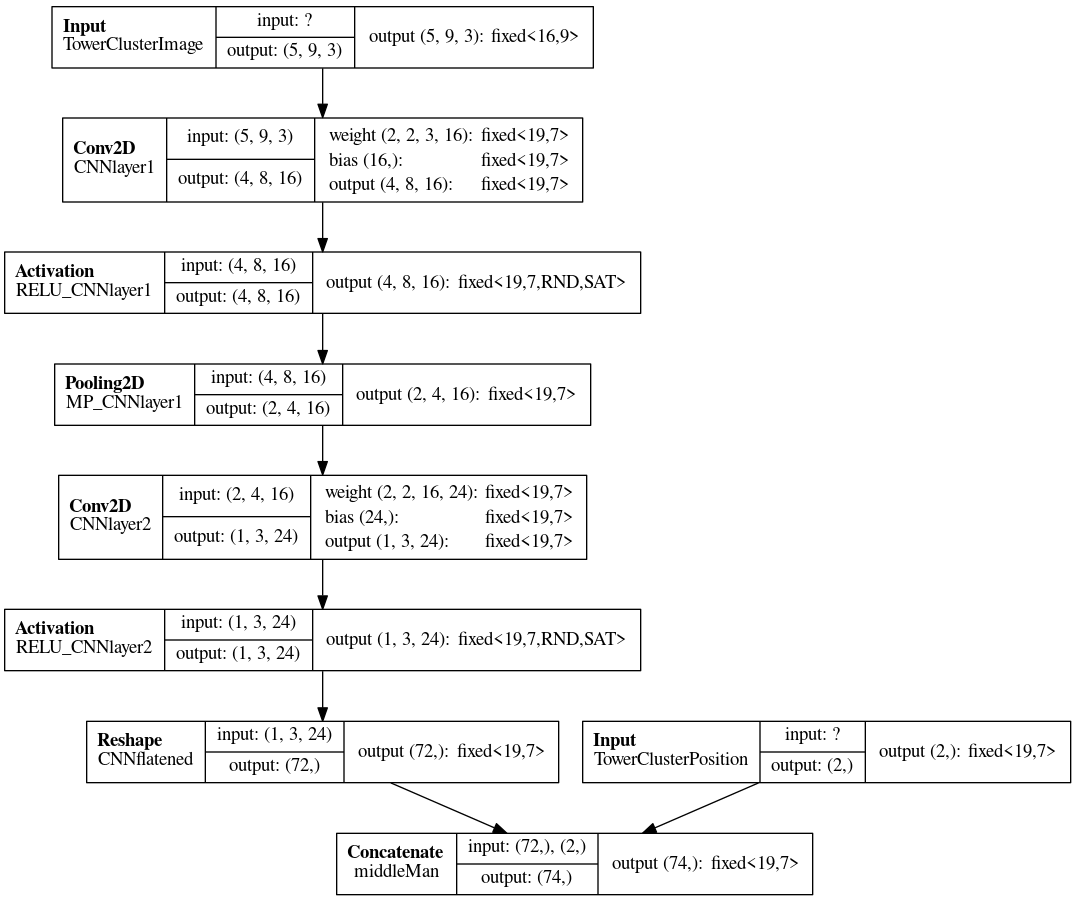

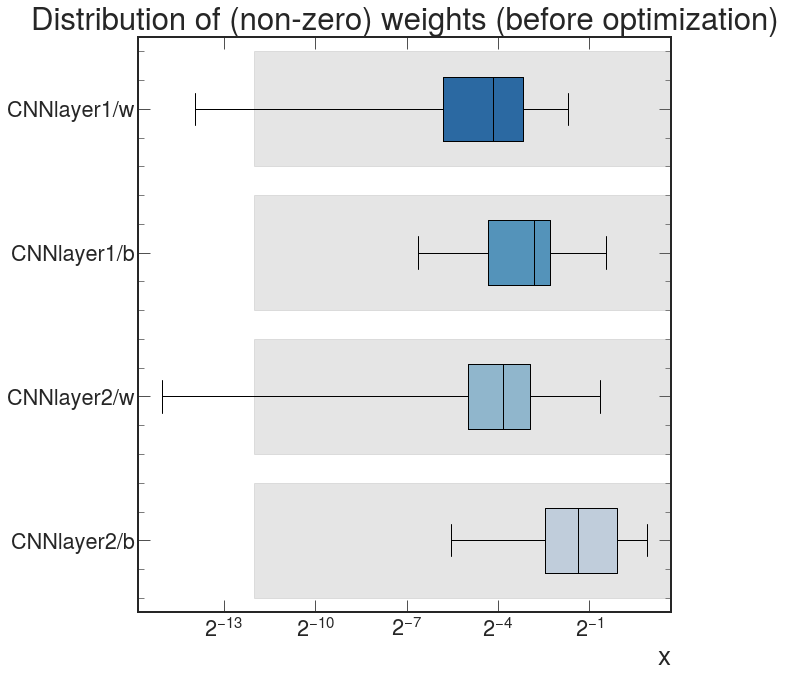

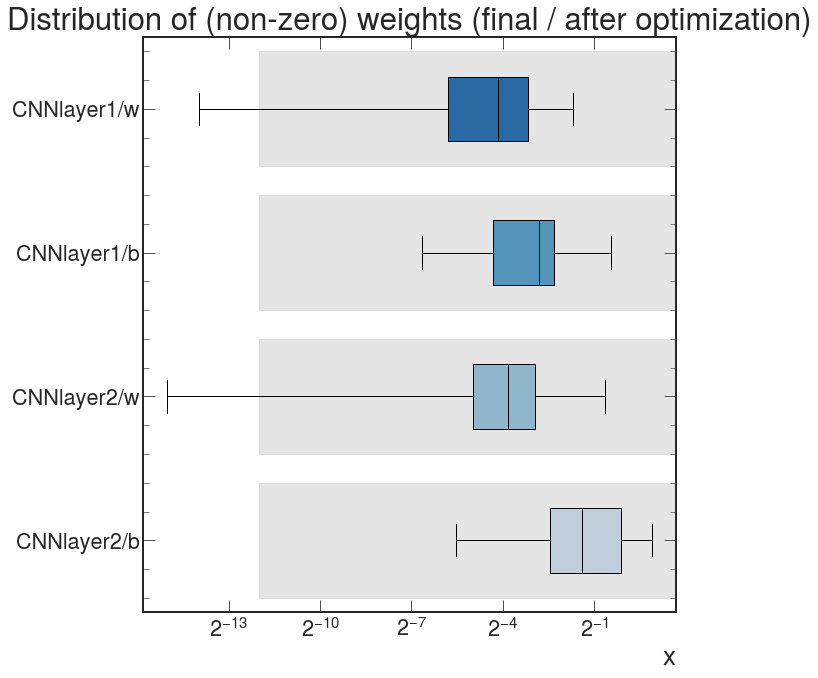

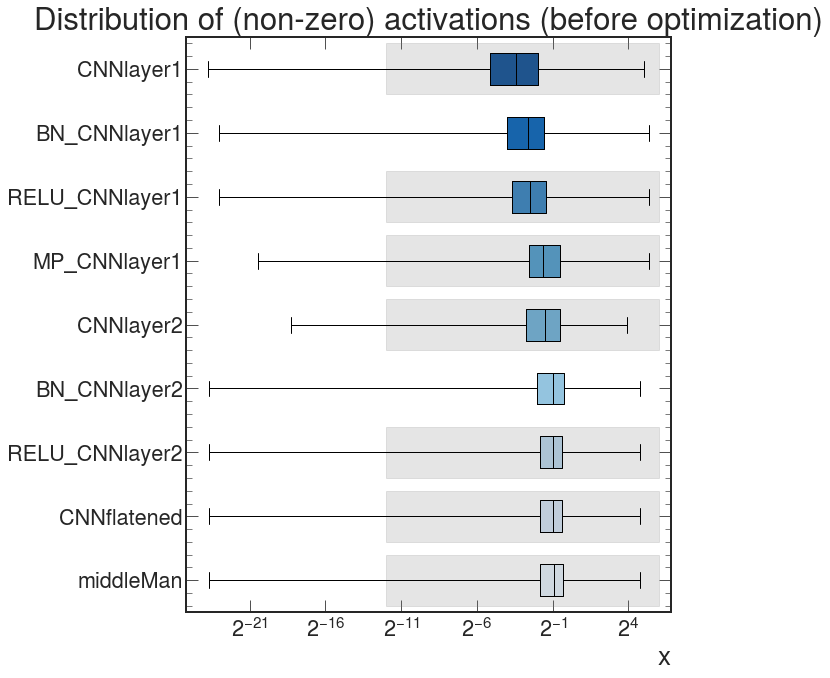

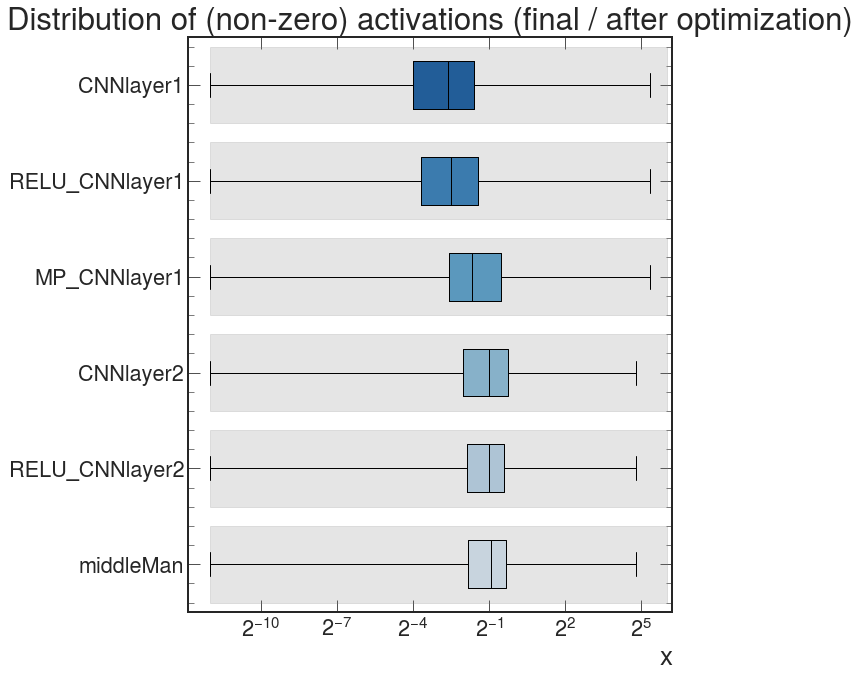

In [7]:
############################## Pass non-quantized CNN model through hls4ml ##############################

hls4ml.model.optimizer.get_optimizer('output_rounding_saturation_mode').configure(layers=['Activation'],
                                                                                  rounding_mode='AP_RND',
                                                                                  saturation_mode='AP_SAT')

# baseline model
CNN_hls_cfg = hls4ml.utils.config_from_keras_model(CNN, granularity='name')
CNN_hls_cfg['Model']['Precision'] = 'ap_fixed<19,7>'
CNN_hls_cfg['Model']['ReuseFactor'] = 1
for Layer in CNN_hls_cfg['LayerName'].keys():
    CNN_hls_cfg['LayerName'][Layer]['Strategy'] = 'Latency'
    CNN_hls_cfg['LayerName'][Layer]['ReuseFactor'] = 1
    CNN_hls_cfg['LayerName'][Layer]['Trace'] = True
    CNN_hls_cfg['LayerName'][Layer]['Precision'] = 'ap_fixed<19,7>'
CNN_hls_cfg['LayerName']['TowerClusterImage']['Precision'] = 'ap_fixed<16,9>'
CNN_hls_cfg['LayerName']['middleMan']['Precision'] = 'ap_fixed<19,7>'
CNN_hls_cfg['LayerName']['middleMan']['Strategy'] = 'Stable'

print(CNN_hls_cfg)

CNN_cfg = hls4ml.converters.create_config(backend='Vivado')
CNN_cfg['IOType']     = 'io_parallel' # Must set this if using CNNs!
CNN_cfg['HLSConfig']  = CNN_hls_cfg
CNN_cfg['KerasModel'] = CNN
CNN_cfg['OutputDir']  = 'CNN/'
CNN_cfg['Part']       = 'xcvu13p-fhgb2104-2L-e'
CNN_cfg['XilinxPart'] = 'xcvu13p-fhgb2104-2L-e'

CNN_hls = hls4ml.converters.keras_to_hls(CNN_cfg)

hls4ml.model.optimizer.get_optimizer('output_rounding_saturation_mode').configure(layers=[])
CNN_hls.compile()

hls4ml.model.profiling.numerical(model=CNN, hls_model=CNN_hls, X=[X1_id_reduced,X2_id_reduced])
hls4ml.utils.plot_model(CNN_hls, show_shapes=True, show_precision=True, to_file=None)

Interpreting Model
Topology:
Layer name: CNNflattened, layer type: Input
Layer name: DNNlayer1, layer type: Dense
  -> Activation (linear), layer name: DNNlayer1
Layer name: RELU_DNNlayer1, layer type: Activation
Layer name: DNNlayer2, layer type: Dense
  -> Activation (linear), layer name: DNNlayer2
Layer name: RELU_DNNlayer2, layer type: Activation
Layer name: DNNout, layer type: Dense
  -> Activation (linear), layer name: DNNout
Layer name: sigmoid_DNNout, layer type: Activation
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'CNNflattened': {'Precision': {'result': 'ap_fixed<16,6>'}, 'Strategy': 'Latency', 'ReuseFactor': 1, 'Trace': True}, 'DNNlayer1': {'Precision': {'weight': 'ap_fixed<6,1>', 'bias': 'ap_fixed<16,6>', 'result': 'ap_fixed<9,6>'}, 'ReuseFactor': 1, 'Strategy': 'Latency', 'Trace': True}, 'DNNlayer1_linear': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>', 'Strategy': '

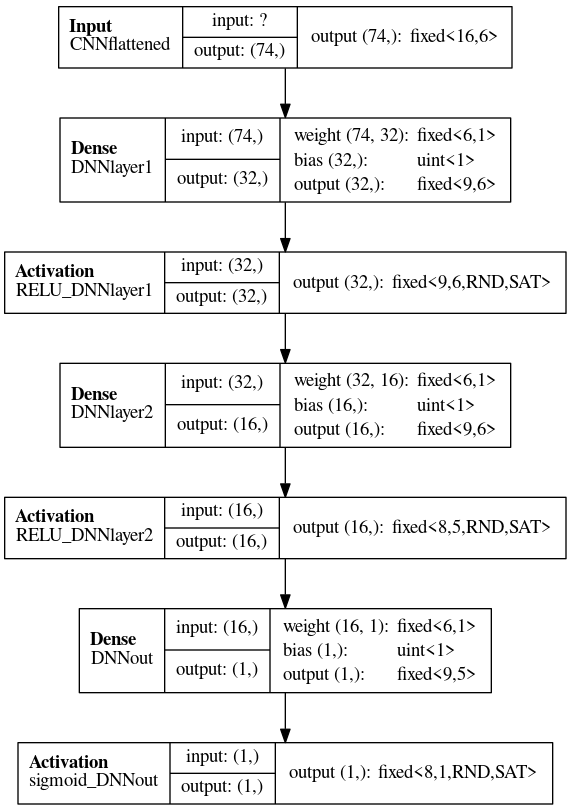

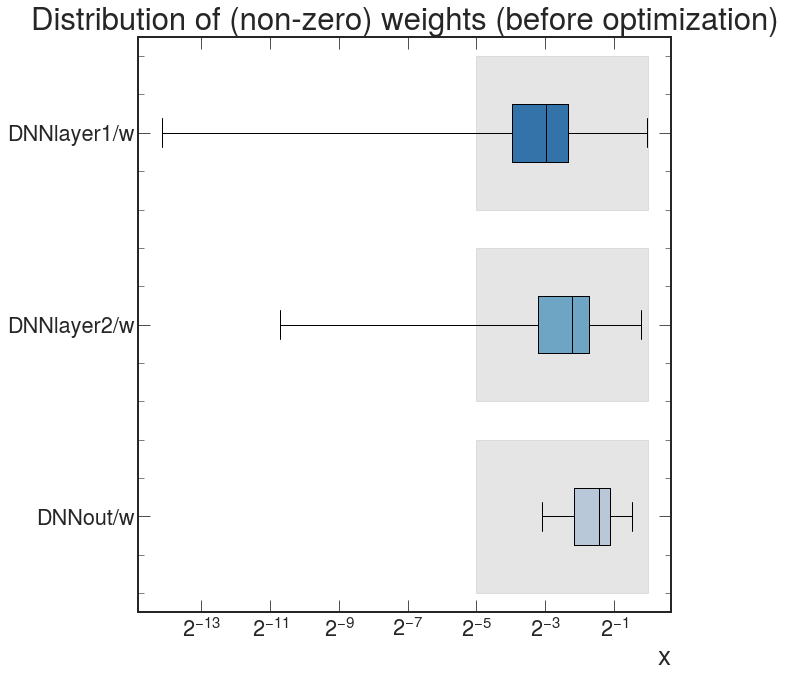

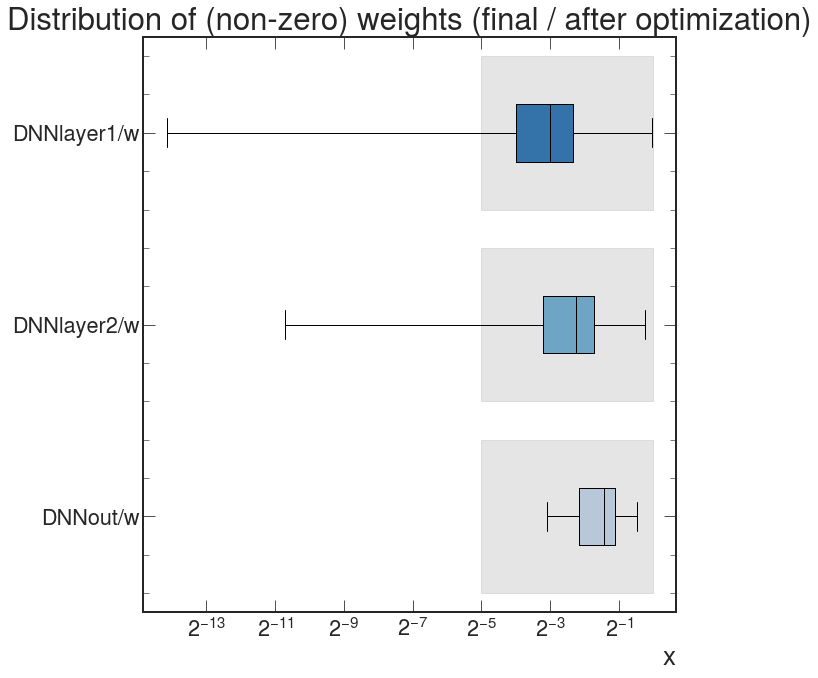

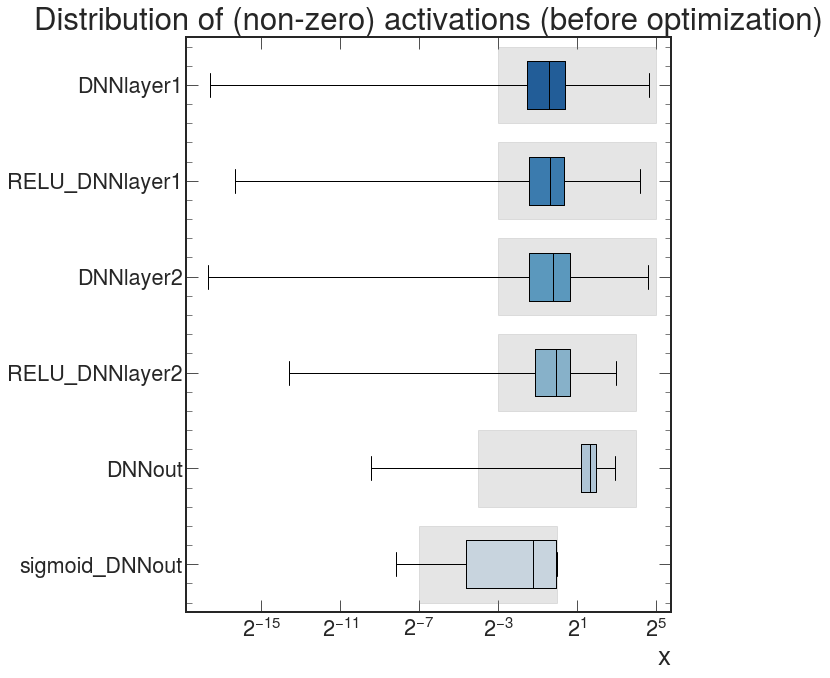

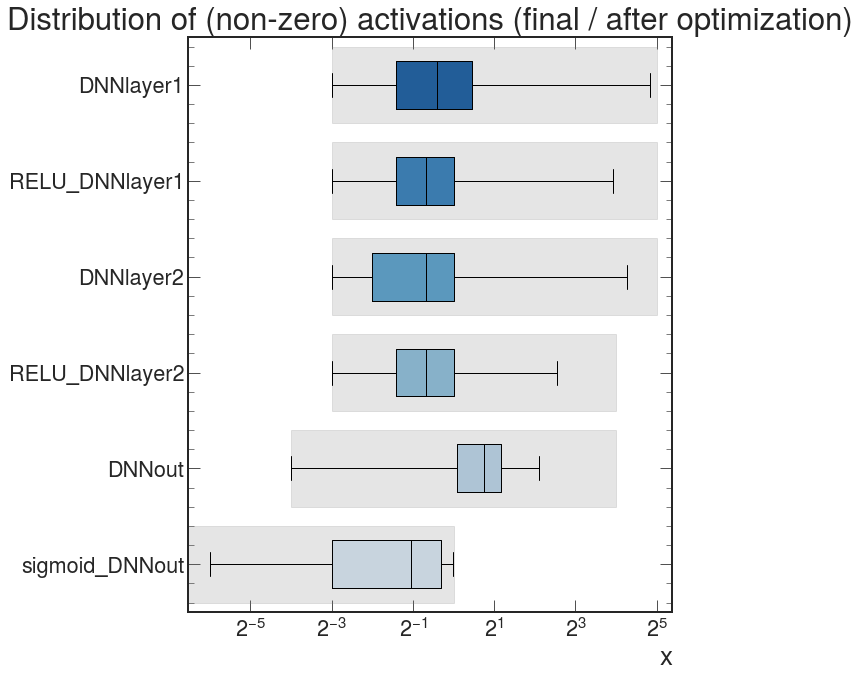

In [8]:
############################## Pass non-quantized identification DNN model through hls4ml ##############################

hls4ml.model.optimizer.get_optimizer('output_rounding_saturation_mode').configure(layers=['Activation'],
                                                                                  rounding_mode='AP_RND',
                                                                                  saturation_mode='AP_SAT')

# baseline model
id_DNN_hls_cfg = hls4ml.utils.config_from_keras_model(DNNident, granularity='name')
id_DNN_hls_cfg['Model']['Precision'] = 'ap_fixed<16,6>'
id_DNN_hls_cfg['Model']['ReuseFactor'] = 1
for Layer in id_DNN_hls_cfg['LayerName'].keys():
    id_DNN_hls_cfg['LayerName'][Layer]['Strategy'] = 'Latency'
    id_DNN_hls_cfg['LayerName'][Layer]['ReuseFactor'] = 1
    id_DNN_hls_cfg['LayerName'][Layer]['Trace'] = True
id_DNN_hls_cfg['LayerName']['DNNlayer1']['Precision']['weight'] = 'ap_fixed<6,1>'
id_DNN_hls_cfg['LayerName']['DNNlayer1']['Precision']['result'] = 'ap_fixed<9,6>'
id_DNN_hls_cfg['LayerName']['RELU_DNNlayer1']['Precision'] = 'ap_fixed<9,6>'

id_DNN_hls_cfg['LayerName']['DNNlayer2']['Precision']['weight'] = 'ap_fixed<6,1>'
id_DNN_hls_cfg['LayerName']['DNNlayer2']['Precision']['result'] = 'ap_fixed<9,6>'
id_DNN_hls_cfg['LayerName']['RELU_DNNlayer2']['Precision'] = 'ap_fixed<8,5>'

id_DNN_hls_cfg['LayerName']['DNNout']['Precision']['weight'] = 'ap_fixed<6,1>'
id_DNN_hls_cfg['LayerName']['DNNout']['Precision']['result'] = 'ap_fixed<9,5>'

id_DNN_hls_cfg['LayerName']['sigmoid_DNNout']['Precision'] = 'ap_fixed<8,1>'
id_DNN_hls_cfg['LayerName']['sigmoid_DNNout']['Strategy'] = 'Stable'

print(id_DNN_hls_cfg)

id_DNN_cfg = hls4ml.converters.create_config(backend='Vivado')
id_DNN_cfg['IOType']     = 'io_parallel'
id_DNN_cfg['HLSConfig']  = id_DNN_hls_cfg
id_DNN_cfg['KerasModel'] = DNNident
id_DNN_cfg['OutputDir']  = 'DNNident/'
id_DNN_cfg['Part']       = 'xcvu13p-fhgb2104-2L-e'
id_DNN_cfg['XilinxPart'] = 'xcvu13p-fhgb2104-2L-e'

DNNident_hls = hls4ml.converters.keras_to_hls(id_DNN_cfg)

hls4ml.model.optimizer.get_optimizer('output_rounding_saturation_mode').configure(layers=[])
DNNident_hls.compile()

id_CNNoutput = np.array(CNN([X1_id_reduced,X2_id_reduced]))

hls4ml.model.profiling.numerical(model=DNNident, hls_model=DNNident_hls, X=id_CNNoutput)
hls4ml.utils.plot_model(DNNident_hls, show_shapes=True, show_precision=True, to_file=None)

## Create HLS model for the calibration DNN - NON-QUANTIZED

Interpreting Model
Topology:
Layer name: CNNflattened, layer type: Input
Layer name: DNNlayer1, layer type: Dense
  -> Activation (linear), layer name: DNNlayer1
Layer name: RELU_DNNlayer1, layer type: Activation
Layer name: DNNlayer2, layer type: Dense
  -> Activation (linear), layer name: DNNlayer2
Layer name: RELU_DNNlayer2, layer type: Activation
Layer name: DNNout, layer type: Dense
  -> Activation (linear), layer name: DNNout
{'Model': {'Precision': 'ap_fixed<20,10>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'CNNflattened': {'Precision': 'ap_fixed<20,7>', 'Strategy': 'Resources', 'ReuseFactor': 1, 'Trace': True}, 'DNNlayer1': {'Precision': {'weight': 'ap_fixed<6,1>', 'bias': 'ap_fixed<16,6>', 'result': 'ap_fixed<16,7>'}, 'ReuseFactor': 1, 'Strategy': 'Resources', 'Trace': True}, 'RELU_DNNlayer1': {'Precision': 'ap_fixed<16,7>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>', 'Strategy': 'Resources', 'Trace': True}, 'DNNlayer2': {'Precision': {'we

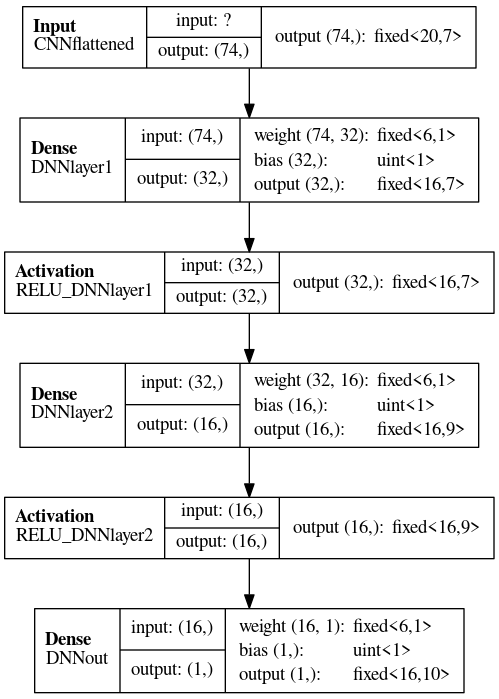

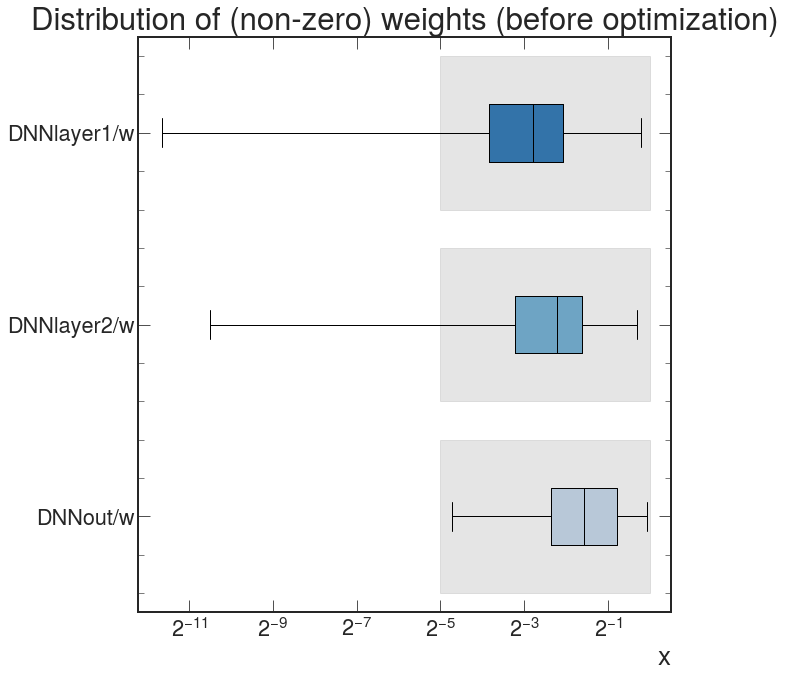

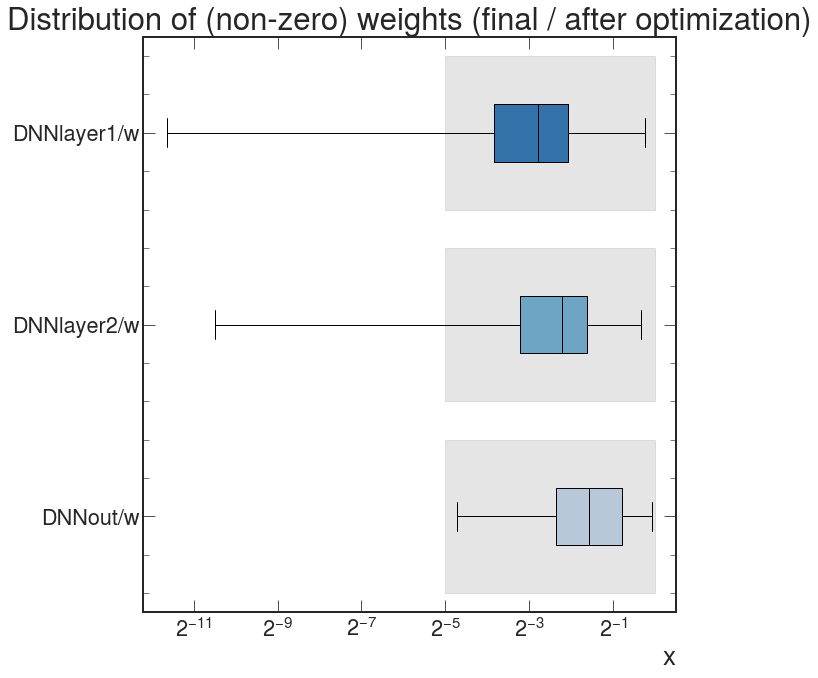

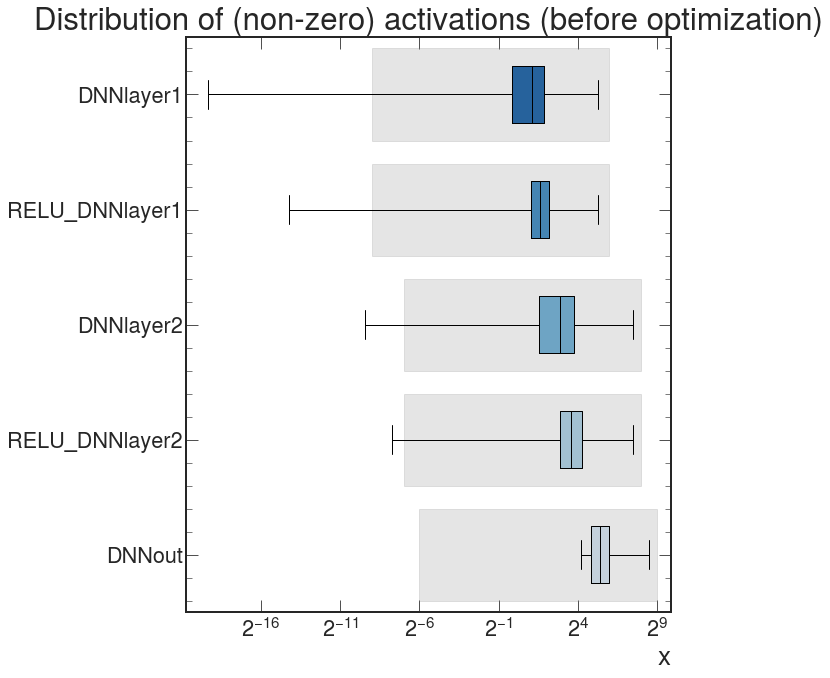

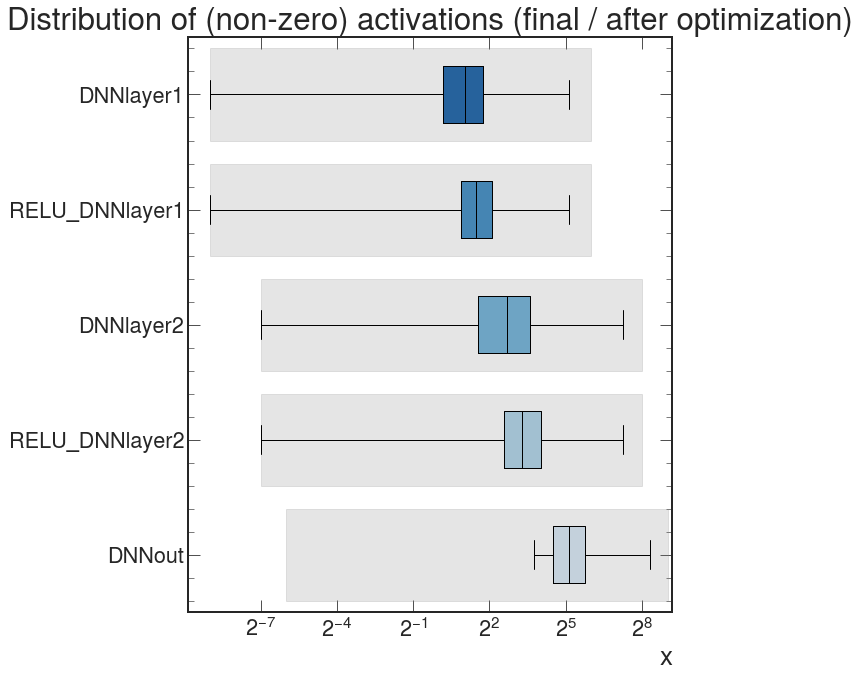

In [9]:
############################## Pass non-quantized calibration DNN model through hls4ml ##############################

# hls4ml.model.optimizer.get_optimizer('output_rounding_saturation_mode').configure(layers=['Activation'],
#                                                                                   rounding_mode='AP_RND',
#                                                                                   saturation_mode='AP_SAT')

# baseline model
cal_DNN_hls_cfg = hls4ml.utils.config_from_keras_model(DNNcalib, granularity='name')
cal_DNN_hls_cfg['Model']['Precision'] = 'ap_fixed<20,10>'
cal_DNN_hls_cfg['Model']['ReuseFactor'] = 1
for Layer in cal_DNN_hls_cfg['LayerName'].keys():
    cal_DNN_hls_cfg['LayerName'][Layer]['Strategy'] = 'Resources'
    cal_DNN_hls_cfg['LayerName'][Layer]['ReuseFactor'] = 1
    cal_DNN_hls_cfg['LayerName'][Layer]['Trace'] = True

cal_DNN_hls_cfg['LayerName']['CNNflattened']['Precision'] = 'ap_fixed<20,7>'

cal_DNN_hls_cfg['LayerName']['DNNlayer1']['Precision']['weight'] = 'ap_fixed<6,1>'
cal_DNN_hls_cfg['LayerName']['DNNlayer1']['Precision']['result'] = 'ap_fixed<16,7>'
cal_DNN_hls_cfg['LayerName']['RELU_DNNlayer1']['Precision'] = 'ap_fixed<16,7>'

cal_DNN_hls_cfg['LayerName']['DNNlayer2']['Precision']['weight'] = 'ap_fixed<6,1>'
cal_DNN_hls_cfg['LayerName']['DNNlayer2']['Precision']['result'] = 'ap_fixed<16,9>'
cal_DNN_hls_cfg['LayerName']['RELU_DNNlayer2']['Precision'] = 'ap_fixed<16,9>'

cal_DNN_hls_cfg['LayerName']['DNNout']['Precision']['weight'] = 'ap_fixed<6,1>'
cal_DNN_hls_cfg['LayerName']['DNNout']['Precision']['result'] = 'ap_fixed<16,10>'
cal_DNN_hls_cfg['LayerName']['DNNout']['Strategy'] = 'Stable'

cal_DNN_hls_cfg['LayerName'].pop('DNNlayer1_linear')
cal_DNN_hls_cfg['LayerName'].pop('DNNlayer2_linear')
cal_DNN_hls_cfg['LayerName'].pop('DNNout_linear')

print(cal_DNN_hls_cfg)

cal_DNN_cfg = hls4ml.converters.create_config(backend='Vivado')
cal_DNN_cfg['IOType']     = 'io_stream'
cal_DNN_cfg['HLSConfig']  = cal_DNN_hls_cfg
cal_DNN_cfg['KerasModel'] = DNNcalib
cal_DNN_cfg['OutputDir']  = 'DNNcalib/'
cal_DNN_cfg['Part']       = 'xcvu13p-fhgb2104-2L-e'
cal_DNN_cfg['XilinxPart'] = 'xcvu13p-fhgb2104-2L-e'

DNNcalib_hls = hls4ml.converters.keras_to_hls(cal_DNN_cfg)

hls4ml.model.optimizer.get_optimizer('output_rounding_saturation_mode').configure(layers=[])
DNNcalib_hls.compile()

cal_CNNoutput = np.array(CNN([X1_cal_reduced,X2_cal_reduced]))

hls4ml.model.profiling.numerical(model=DNNcalib, hls_model=DNNcalib_hls, X=cal_CNNoutput)
hls4ml.utils.plot_model(DNNcalib_hls, show_shapes=True, show_precision=True, to_file=None)

# QUANTIZED MODELS THEN

## Create HLS model for the identification CNN and DNN - QUANTIZED

Interpreting Model
Topology:
Layer name: TowerClusterImage, layer type: Input
Layer name: CNNpBNlayer1, layer type: QConv2DBatchnorm
  -> Activation (linear), layer name: CNNpBNlayer1
Layer name: RELU_CNNpBNlayer1, layer type: QActivation
  -> Activation (quantized_relu(10,7)), layer name: RELU_CNNpBNlayer1
Layer name: MP_CNNpBNlayer1, layer type: MaxPooling2D
Layer name: CNNpBNlayer2, layer type: QConv2DBatchnorm
  -> Activation (linear), layer name: CNNpBNlayer2
Layer name: RELU_CNNpBNlayer2, layer type: QActivation
  -> Activation (quantized_relu(9,6)), layer name: RELU_CNNpBNlayer2
Layer name: TowerClusterPosition, layer type: Input
Layer name: middleMan, layer type: Concatenate
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'TowerClusterImage': {'Precision': 'ap_fixed<16,9>', 'Strategy': 'Latency', 'ReuseFactor': 1, 'Trace': True}, 'CNNpBNlayer1': {'Precision': 'ap_fixed<16,7>', 'ReuseFactor': 1, 'Strategy': 'Latency', 'Trace': Tr

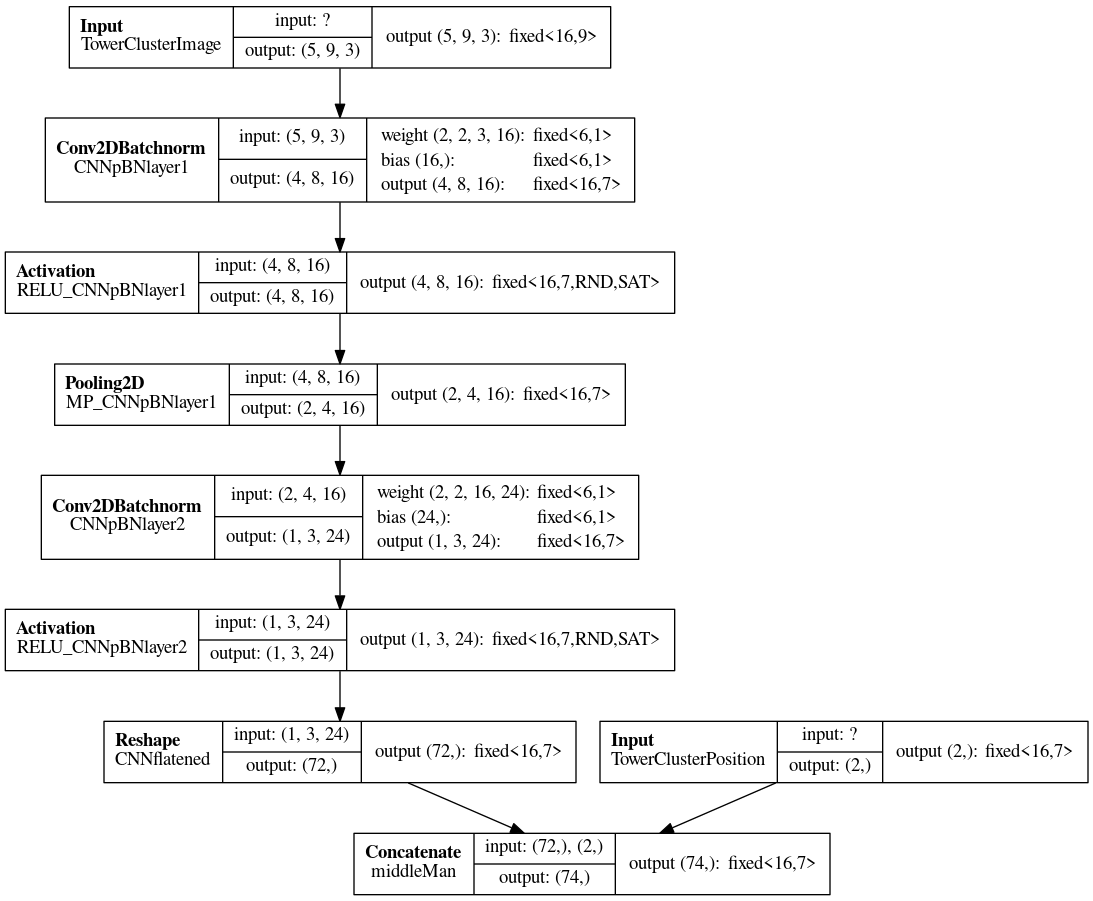

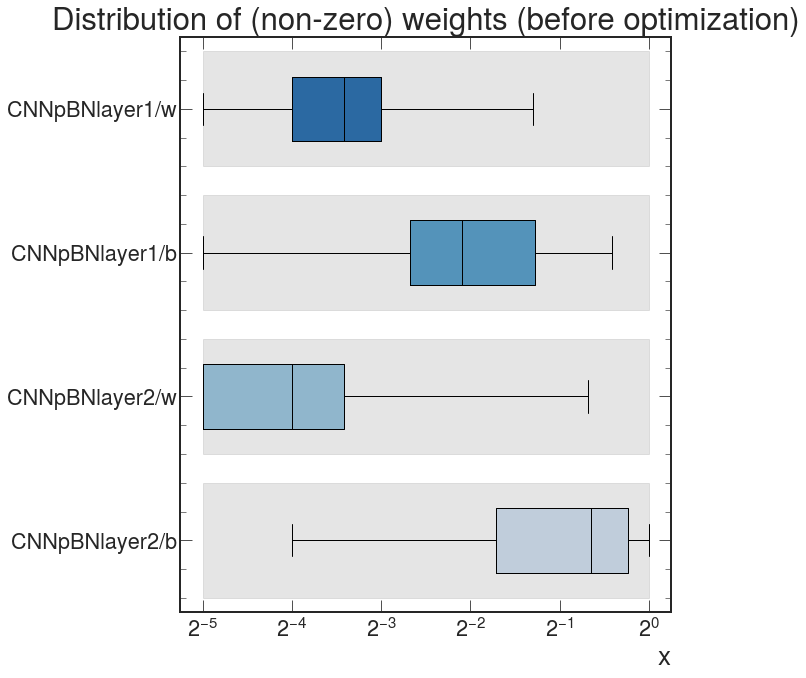

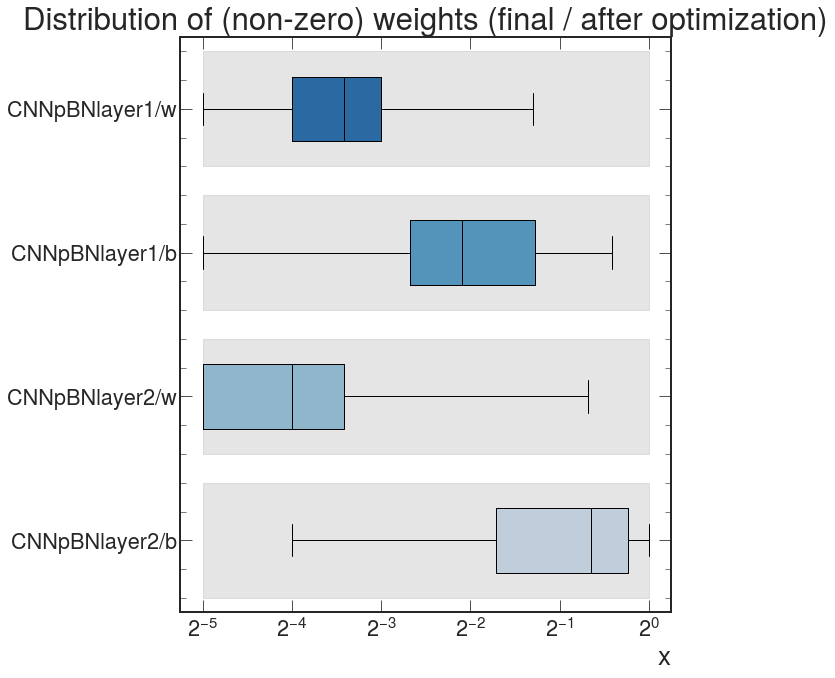

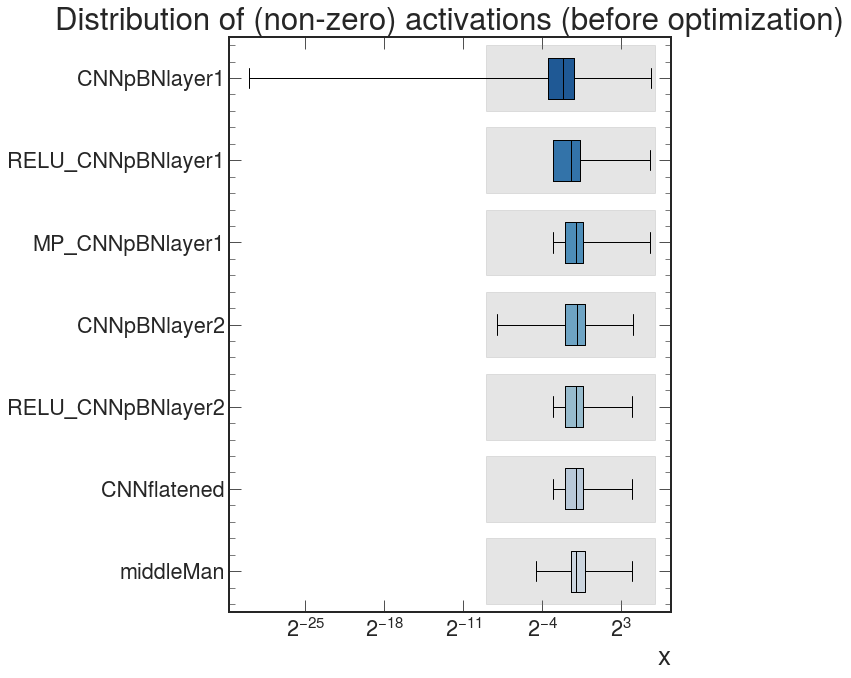

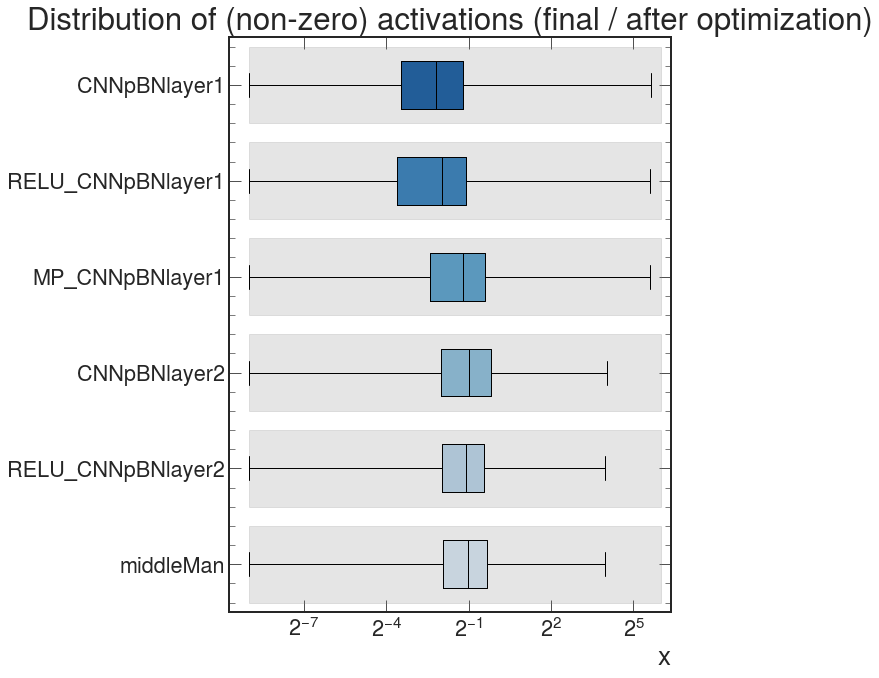

In [10]:
############################## Pass quantized CNN model through hls4ml ##############################

hls4ml.model.optimizer.get_optimizer('output_rounding_saturation_mode').configure(layers=['Activation'],
                                                                                  rounding_mode='AP_RND',
                                                                                  saturation_mode='AP_SAT')

# baseline model
QCNN_hls_cfg = hls4ml.utils.config_from_keras_model(QCNN, granularity='name')
QCNN_hls_cfg['Model']['Precision'] = 'ap_fixed<16,6>'
QCNN_hls_cfg['Model']['ReuseFactor'] = 1
for Layer in QCNN_hls_cfg['LayerName'].keys():
    QCNN_hls_cfg['LayerName'][Layer]['Strategy'] = 'Latency'
    QCNN_hls_cfg['LayerName'][Layer]['ReuseFactor'] = 1
    QCNN_hls_cfg['LayerName'][Layer]['Trace'] = True
    QCNN_hls_cfg['LayerName'][Layer]['Precision'] = 'ap_fixed<16,7>'

QCNN_hls_cfg['LayerName']['TowerClusterImage']['Precision'] = 'ap_fixed<16,9>'
QCNN_hls_cfg['LayerName']['middleMan']['Precision'] = 'ap_fixed<16,7>'
QCNN_hls_cfg['LayerName']['middleMan']['Strategy'] = 'Stable'

print(QCNN_hls_cfg)

QCNN_cfg = hls4ml.converters.create_config(backend='Vivado')
QCNN_cfg['IOType']     = 'io_parallel' # Must set this if using CNNs!
QCNN_cfg['HLSConfig']  = QCNN_hls_cfg
QCNN_cfg['KerasModel'] = QCNN
QCNN_cfg['OutputDir']  = 'QCNN/'
QCNN_cfg['Part']       = 'xcvu13p-fhgb2104-2L-e'
QCNN_cfg['XilinxPart'] = 'xcvu13p-fhgb2104-2L-e'

QCNN_hls = hls4ml.converters.keras_to_hls(QCNN_cfg)

hls4ml.model.optimizer.get_optimizer('output_rounding_saturation_mode').configure(layers=[])
QCNN_hls.compile()

hls4ml.model.profiling.numerical(model=QCNN, hls_model=QCNN_hls, X=[X1_id_reduced,X2_id_reduced])
hls4ml.utils.plot_model(QCNN_hls, show_shapes=True, show_precision=True, to_file=None)

Interpreting Model
Topology:
Layer name: CNNflattened, layer type: Input
Layer name: DNNlayer1, layer type: QDense
  -> Activation (linear), layer name: DNNlayer1
Layer name: RELU_DNNlayer1, layer type: QActivation
  -> Activation (quantized_relu(9,6)), layer name: RELU_DNNlayer1
Layer name: DNNlayer2, layer type: QDense
  -> Activation (linear), layer name: DNNlayer2
Layer name: RELU_DNNlayer2, layer type: QActivation
  -> Activation (quantized_relu(8,5)), layer name: RELU_DNNlayer2
Layer name: DNNout, layer type: QDense
  -> Activation (linear), layer name: DNNout
Layer name: sigmoid_DNNout, layer type: Activation
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'CNNflattened': {'Precision': 'ap_fixed<16,7>', 'Strategy': 'Latency', 'ReuseFactor': 1, 'Trace': True}, 'DNNlayer1': {'Precision': 'ap_fixed<16,7>', 'ReuseFactor': 1, 'Strategy': 'Latency', 'Trace': True}, 'DNNlayer1_linear': {'Precision': 'ap_fixed<16,7>', 'ReuseFactor': 1, '

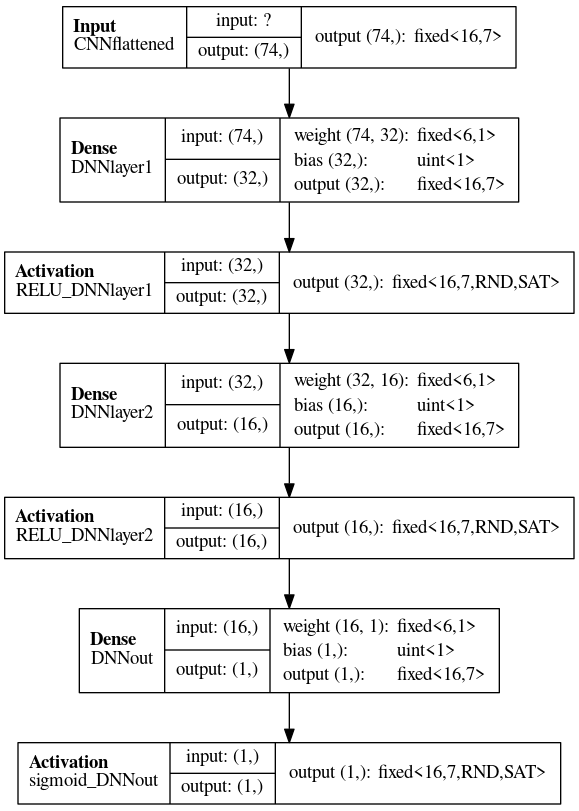

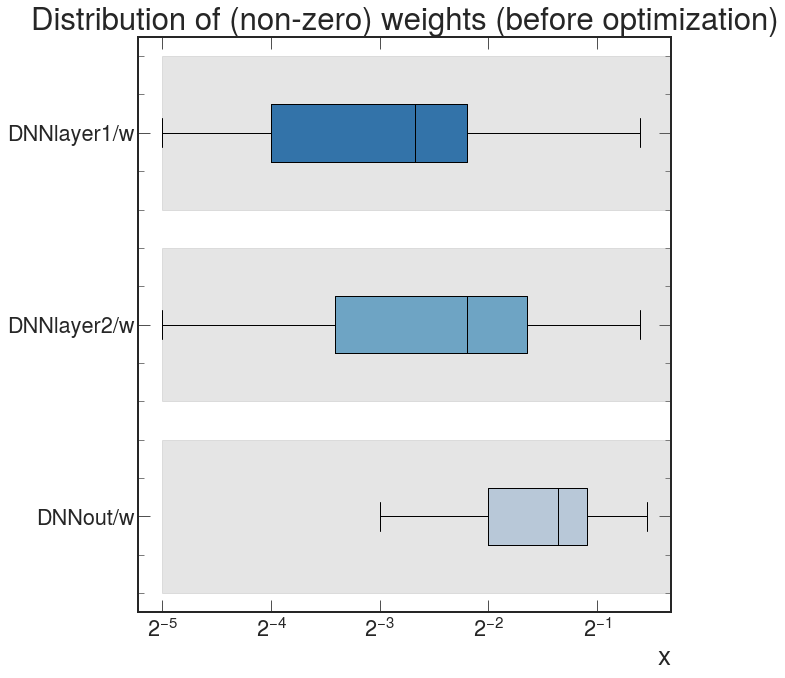

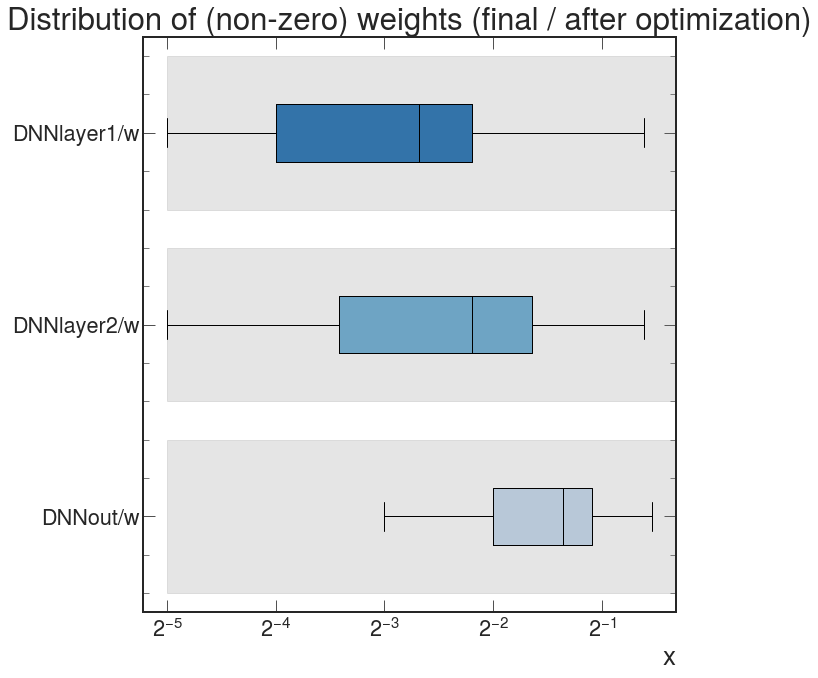

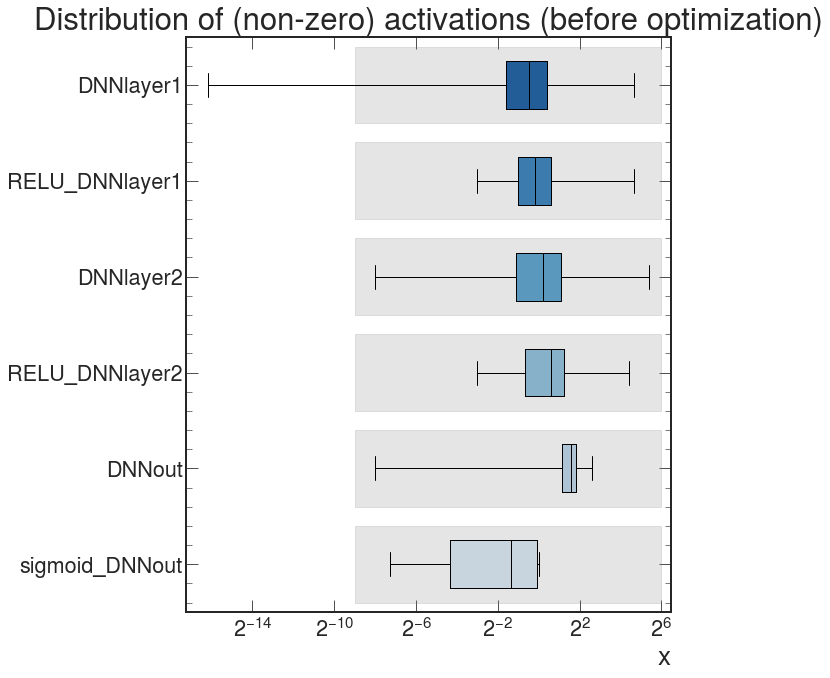

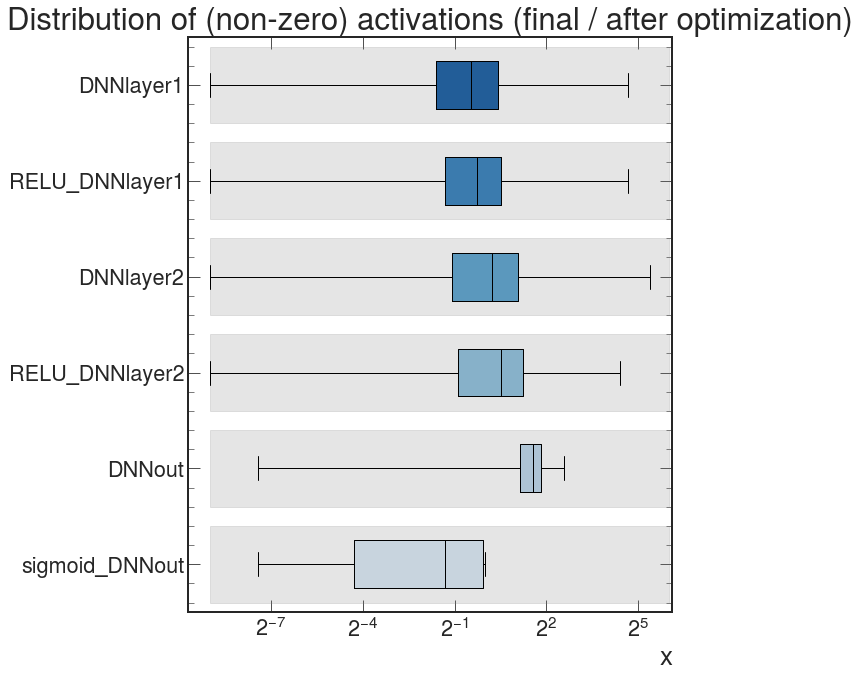

In [11]:
############################## Pass quantized identification DNN model through hls4ml ##############################

hls4ml.model.optimizer.get_optimizer('output_rounding_saturation_mode').configure(layers=['Activation'],
                                                                                  rounding_mode='AP_RND',
                                                                                  saturation_mode='AP_SAT')

# baseline model
id_QDNN_hls_cfg = hls4ml.utils.config_from_keras_model(QDNNident, granularity='name')
id_QDNN_hls_cfg['Model']['Precision'] = 'ap_fixed<16,6>'
id_QDNN_hls_cfg['Model']['ReuseFactor'] = 1
for Layer in id_QDNN_hls_cfg['LayerName'].keys():
    id_QDNN_hls_cfg['LayerName'][Layer]['Strategy'] = 'Latency'
    id_QDNN_hls_cfg['LayerName'][Layer]['ReuseFactor'] = 1
    id_QDNN_hls_cfg['LayerName'][Layer]['Trace'] = True
    id_QDNN_hls_cfg['LayerName'][Layer]['Precision'] = 'ap_fixed<16,7>'
id_QDNN_hls_cfg['LayerName']['sigmoid_DNNout']['Strategy'] = 'Stable'

print(id_QDNN_hls_cfg)

id_QDNN_cfg = hls4ml.converters.create_config(backend='Vivado')
id_QDNN_cfg['IOType']     = 'io_parallel'
id_QDNN_cfg['HLSConfig']  = id_QDNN_hls_cfg
id_QDNN_cfg['KerasModel'] = QDNNident
id_QDNN_cfg['OutputDir']  = 'QDNNident/'
id_QDNN_cfg['Part']       = 'xcvu13p-fhgb2104-2L-e'
id_QDNN_cfg['XilinxPart'] = 'xcvu13p-fhgb2104-2L-e'

QDNNident_hls = hls4ml.converters.keras_to_hls(id_QDNN_cfg)

hls4ml.model.optimizer.get_optimizer('output_rounding_saturation_mode').configure(layers=[])
QDNNident_hls.compile()

id_QCNNoutput = np.array(QCNN([X1_id_reduced,X2_id_reduced]))

hls4ml.model.profiling.numerical(model=QDNNident, hls_model=QDNNident_hls, X=id_QCNNoutput)
hls4ml.utils.plot_model(QDNNident_hls, show_shapes=True, show_precision=True, to_file=None)

## Create HLS model for the calibration DNN - QUANTIZED

Interpreting Model
Topology:
Layer name: CNNflattened, layer type: Input
Layer name: DNNlayer1, layer type: QDense
  -> Activation (linear), layer name: DNNlayer1
Layer name: RELU_DNNlayer1, layer type: QActivation
  -> Activation (quantized_relu(9,6)), layer name: RELU_DNNlayer1
Layer name: DNNlayer2, layer type: QDense
  -> Activation (linear), layer name: DNNlayer2
Layer name: RELU_DNNlayer2, layer type: QActivation
  -> Activation (quantized_relu(9,6)), layer name: RELU_DNNlayer2
Layer name: DNNout, layer type: QDense
  -> Activation (linear), layer name: DNNout
{'Model': {'Precision': 'ap_fixed<20,9>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'CNNflattened': {'Precision': 'ap_fixed<16,7>', 'Strategy': 'Resources', 'ReuseFactor': 1, 'Trace': True}, 'DNNlayer1': {'Precision': {'weight': 'ap_fixed<6,2>', 'result': 'ap_fixed<20,7>'}, 'ReuseFactor': 1, 'Strategy': 'Resources', 'Trace': True}, 'DNNlayer1_linear': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_si

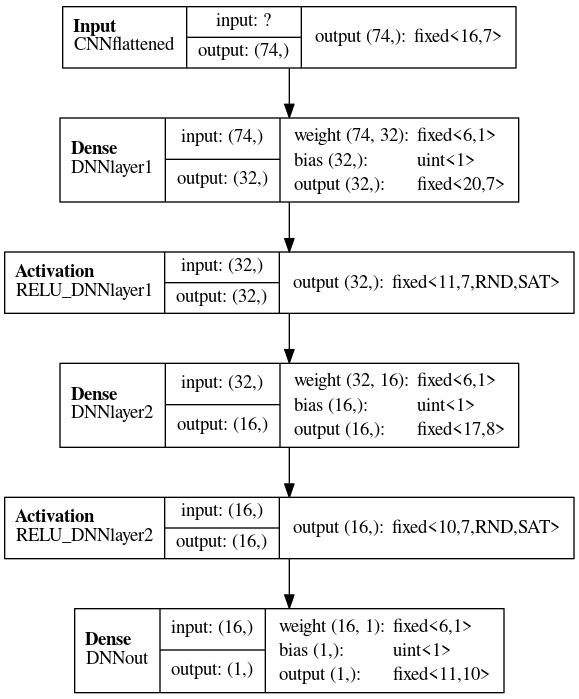

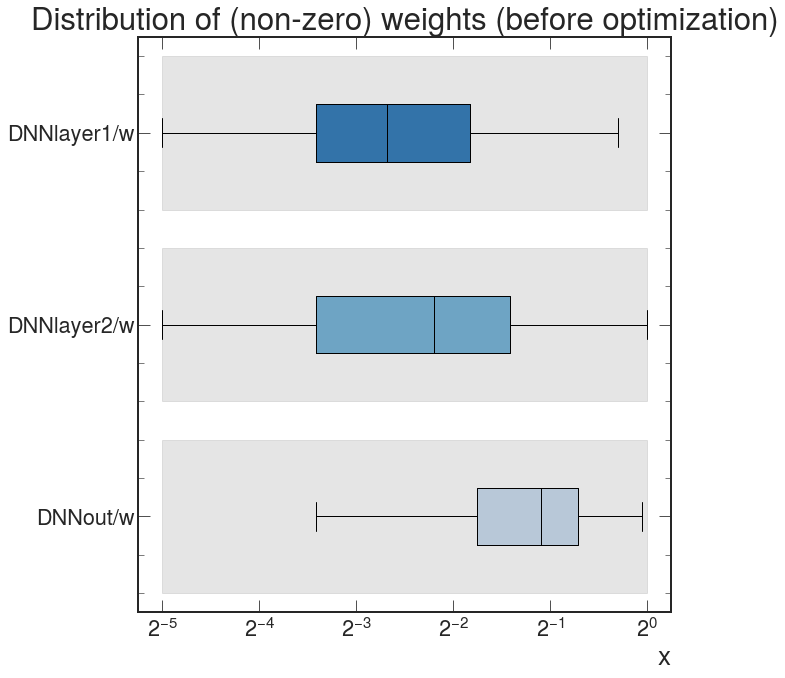

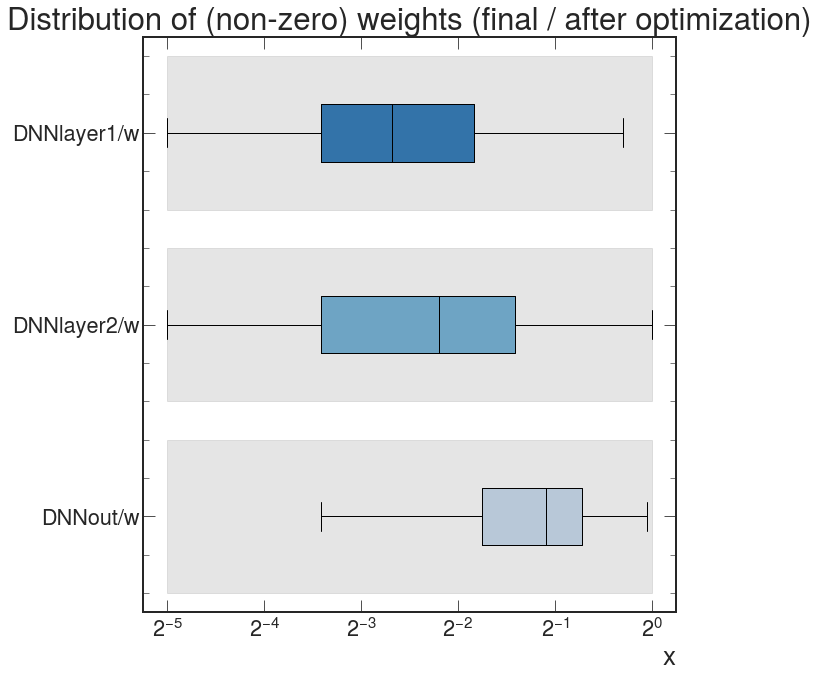

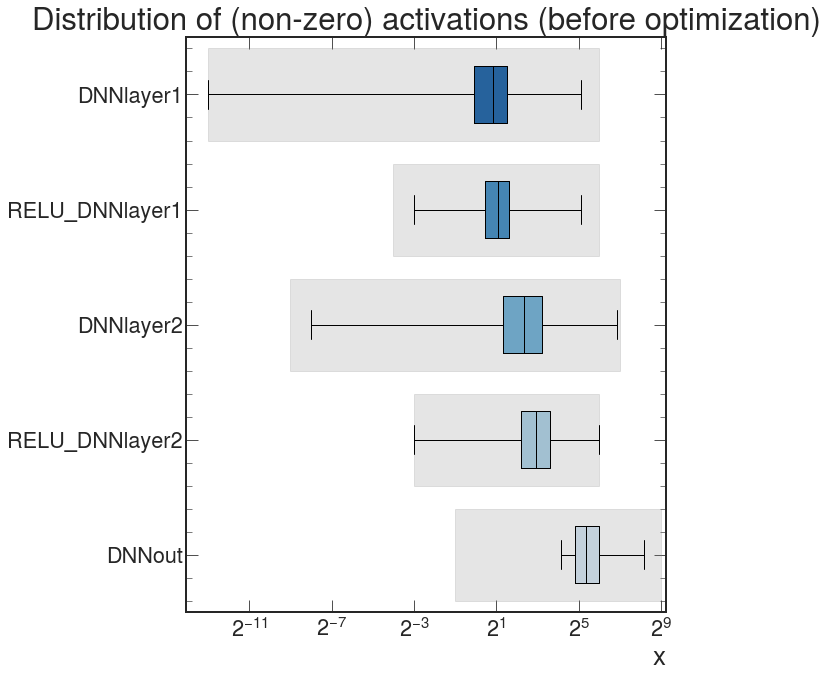

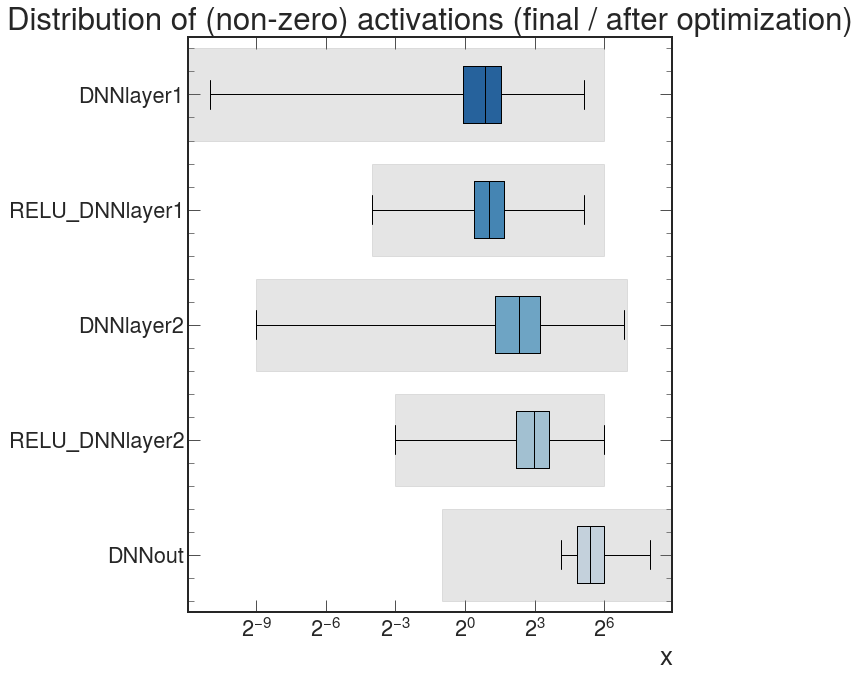

In [30]:
############################## Pass quantized calibration DNN model through hls4ml ##############################

hls4ml.model.optimizer.get_optimizer('output_rounding_saturation_mode').configure(layers=['Activation'],
                                                                                  rounding_mode='AP_RND',
                                                                                  saturation_mode='AP_SAT')

# baseline model
cal_QDNN_hls_cfg = hls4ml.utils.config_from_keras_model(QDNNcalib, granularity='name')
cal_QDNN_hls_cfg['Model']['Precision'] = 'ap_fixed<20,9>'
cal_QDNN_hls_cfg['Model']['ReuseFactor'] = 1
for Layer in cal_QDNN_hls_cfg['LayerName'].keys():
    cal_QDNN_hls_cfg['LayerName'][Layer]['Strategy'] = 'Resources'
    cal_QDNN_hls_cfg['LayerName'][Layer]['ReuseFactor'] = 1
    cal_QDNN_hls_cfg['LayerName'][Layer]['Trace'] = True

cal_QDNN_hls_cfg['LayerName']['CNNflattened']['Precision'] = 'ap_fixed<16,7>'
    
cal_QDNN_hls_cfg['LayerName']['DNNlayer1']['Precision']['weight'] = 'ap_fixed<6,2>'
cal_QDNN_hls_cfg['LayerName']['DNNlayer1']['Precision']['result'] = 'ap_fixed<20,7>'
cal_QDNN_hls_cfg['LayerName']['RELU_DNNlayer1']['Precision'] = 'ap_fixed<11,7>'

cal_QDNN_hls_cfg['LayerName']['DNNlayer2']['Precision']['weight'] = 'ap_fixed<6,2>'
cal_QDNN_hls_cfg['LayerName']['DNNlayer2']['Precision']['result'] = 'ap_fixed<17,8>'
cal_QDNN_hls_cfg['LayerName']['RELU_DNNlayer2']['Precision'] = 'ap_fixed<10,7>'

cal_QDNN_hls_cfg['LayerName']['DNNout']['Precision']['weight'] = 'ap_fixed<6,1>'
cal_QDNN_hls_cfg['LayerName']['DNNout']['Precision']['result'] = 'ap_fixed<11,10>'
cal_QDNN_hls_cfg['LayerName']['DNNout']['Strategy'] = 'Stable'

print(cal_QDNN_hls_cfg)

cal_QDNN_cfg = hls4ml.converters.create_config(backend='Vivado')
cal_QDNN_cfg['IOType']     = 'io_stream'
cal_QDNN_cfg['HLSConfig']  = cal_QDNN_hls_cfg
cal_QDNN_cfg['KerasModel'] = QDNNcalib
cal_QDNN_cfg['OutputDir']  = 'QDNNcalib/'
cal_QDNN_cfg['Part']       = 'xcvu13p-fhgb2104-2L-e'
cal_QDNN_cfg['XilinxPart'] = 'xcvu13p-fhgb2104-2L-e'

QDNNcalib_hls = hls4ml.converters.keras_to_hls(cal_QDNN_cfg)

hls4ml.model.optimizer.get_optimizer('output_rounding_saturation_mode').configure(layers=[])
QDNNcalib_hls.compile()

cal_QCNNoutput = np.array(QCNN([X1_cal_reduced,X2_cal_reduced]))

hls4ml.model.profiling.numerical(model=QDNNcalib, hls_model=QDNNcalib_hls, X=cal_QCNNoutput)
hls4ml.utils.plot_model(QDNNcalib_hls, show_shapes=True, show_precision=True, to_file=None)

# COMPARE HLS TO KERAS AND QKERAS MODELS

In [13]:
def plotROC(Y, y_pred, y_pred_hls4ml, label="Model"):
    
    accuracy_keras  = float(accuracy_score(np.argmax(Y,axis=1), np.argmax(y_pred,axis=1), normalize=True))
    accuracy_hls4ml = float(accuracy_score(np.argmax(Y,axis=1), np.argmax(y_pred_hls4ml,axis=1), normalize=True))

    print("Accuracy Keras:  {}".format(accuracy_keras))
    print("Accuracy hls4ml: {}".format(accuracy_hls4ml))
    
    fig, ax = plt.subplots(figsize=(10, 10))

    FPR, TPR, THR = metrics.roc_curve(Y, y_pred)
    AUC = metrics.roc_auc_score(Y, y_pred)
    
    FPR_HLS, TPR_HLS, THR_HLS = metrics.roc_curve(Y, y_pred_hls4ml)
    AUC_HLS = metrics.roc_auc_score(Y, y_pred_hls4ml)
    
    plt.plot(TPR, FPR, label=label+' ROC, AUC = %.3f' % (AUC),   color='blue',lw=2)
    plt.plot(TPR_HLS, FPR_HLS, label='HLS ROC, AUC = %.3f' % (AUC_HLS), color='green',lw=2)
    
    plt.legend(loc = 'upper left', fontsize=16)
    plt.xlabel('Signal Efficiency')
    plt.ylabel('Background Efficiency')
    mplhep.cms.label('Phase-2 Simulation', data=True, rlabel='14 TeV, 200 PU')
    plt.ylim(0.01,1.)
    plt.xlim(0.7,1.)

In [14]:
# non-quantized models ID
y_ident        = DNNident.predict(CNN.predict([X1_id, X2_id]))
y_ident_hls4ml = DNNident_hls.predict(CNN_hls.predict([X1_id, X2_id]))

In [15]:
# quantized models ID
y_ident_q        = QDNNident.predict(QCNN.predict([X1_id, X2_id]))
y_ident_hls4ml_q = QDNNident_hls.predict(QCNN_hls.predict([X1_id, X2_id]))

In [16]:
# non-quantized models CALIB
y_calib        = DNNcalib.predict(CNN.predict([X1_cal, X2_cal]))
y_calib_hls4ml = DNNcalib_hls.predict(CNN_hls.predict([X1_cal, X2_cal]))

In [17]:
# quantized models CALIB
y_calib_q        = QDNNcalib.predict(QCNN.predict([X1_cal, X2_cal]))
y_calib_hls4ml_q = QDNNcalib_hls.predict(QCNN_hls.predict([X1_cal, X2_cal]))

Accuracy Keras:  1.0
Accuracy hls4ml: 1.0
Accuracy Keras:  1.0
Accuracy hls4ml: 1.0


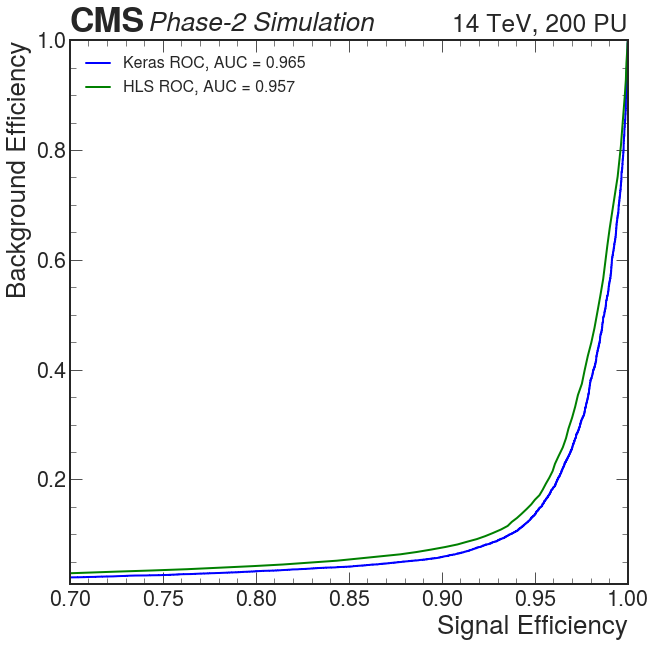

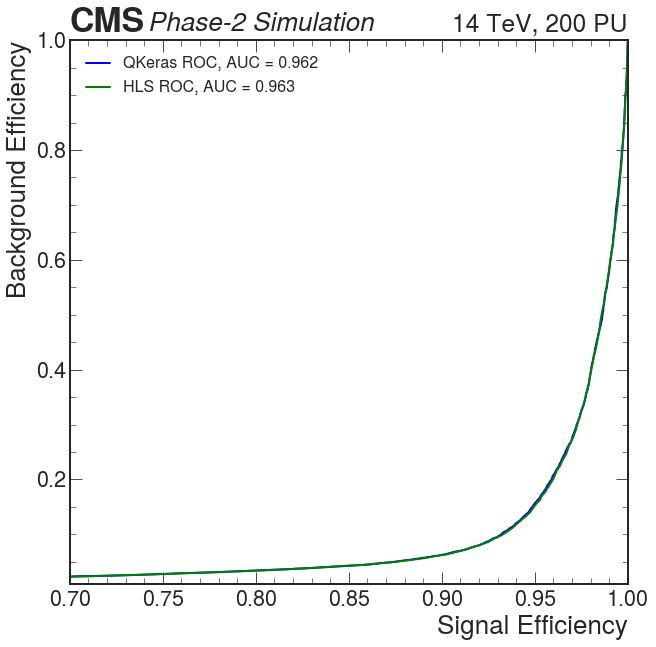

In [18]:
# Plot the floating point model:    
plotROC(Y_id,y_ident,y_ident_hls4ml,label="Keras") 

# Plot the quantized QKeras model
plotROC(Y_id,y_ident_q,y_ident_hls4ml_q,label="QKeras") 

In [19]:
gen = Y_cal[:,0]

response_base = y_calib.ravel() / gen
response_hls4ml = y_calib_hls4ml.ravel() / gen
response_q = y_calib_q.ravel() / gen
response_q_hls4ml = y_calib_hls4ml_q.ravel() / gen

(exptext: Custom Text(0.0, 1, 'CMS'),
 expsuffix: Custom Text(0.0, 1.005, 'Phase-2 Simulation'))

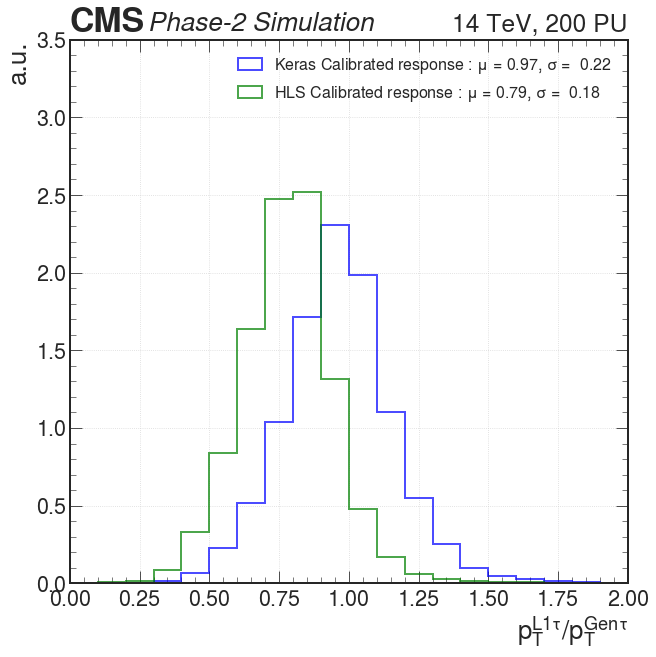

In [20]:
plt.figure(figsize=(10,10))
plt.hist(response_base,     bins=np.arange(0,5,0.1), label=r'Keras Calibrated response : $\mu$ = %.2f, $\sigma$ =  %.2f' % (np.mean(response_base), np.std(response_base)), color='blue', lw=2, density=True, histtype='step', alpha=0.7)
plt.hist(response_hls4ml,   bins=np.arange(0,5,0.1), label=r'HLS Calibrated response : $\mu$ = %.2f, $\sigma$ =  %.2f' % (np.mean(response_hls4ml), np.std(response_hls4ml)), color='green',lw=2, density=True, histtype='step', alpha=0.7)
plt.xlabel(r'$p_{T}^{L1 \tau} / p_{T}^{Gen \tau}$')
plt.ylabel(r'a.u.')
plt.xlim(0., 2.)
plt.ylim(0., 3.5)
plt.legend(loc = 'upper right', fontsize=16)
plt.grid(linestyle='dotted')
mplhep.cms.label('Phase-2 Simulation', data=True, rlabel='14 TeV, 200 PU')

(exptext: Custom Text(0.0, 1, 'CMS'),
 expsuffix: Custom Text(0.0, 1.005, 'Phase-2 Simulation'))

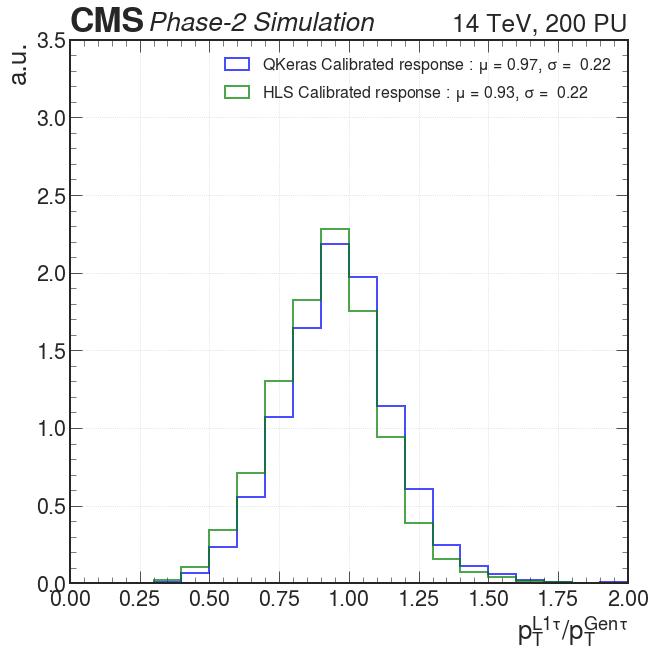

In [21]:
plt.figure(figsize=(10,10))
plt.hist(response_q,        bins=np.arange(0,5,0.1), label=r'QKeras Calibrated response : $\mu$ = %.2f, $\sigma$ =  %.2f' % (np.mean(response_q), np.std(response_q)), color='blue', lw=2, density=True, histtype='step', alpha=0.7)
plt.hist(response_q_hls4ml, bins=np.arange(0,5,0.1), label=r'HLS Calibrated response : $\mu$ = %.2f, $\sigma$ =  %.2f' % (np.mean(response_q_hls4ml), np.std(response_q_hls4ml)), color='green', lw=2, density=True, histtype='step', alpha=0.7)
plt.xlabel(r'$p_{T}^{L1 \tau} / p_{T}^{Gen \tau}$')
plt.ylabel(r'a.u.')
plt.xlim(0., 2.)
plt.ylim(0., 3.5)
plt.legend(loc = 'upper right', fontsize=16)
plt.grid(linestyle='dotted')
mplhep.cms.label('Phase-2 Simulation', data=True, rlabel='14 TeV, 200 PU')

In [22]:
# keras = CNN.predict([X1_cal, X2_cal]).ravel()
# hls = CNN_hls.predict([X1_cal, X2_cal]).ravel()

In [23]:
# plt.figure(figsize=(10,10))
# plt.hist(keras,      bins=np.arange(-4,34,0.1), label=r'Keras Calibrated response : $\mu$ = %.2f, $\sigma$ =  %.2f' % (np.mean(keras), np.std(keras)), color='blue', lw=2, density=True, histtype='step', alpha=0.7)
# plt.hist(hls,    bins=np.arange(-4,34,0.1), label=r'HLS Calibrated response : $\mu$ = %.2f, $\sigma$ =  %.2f' % (np.mean(hls), np.std(hls)), color='green',lw=2, density=True, histtype='step', alpha=0.7)
# plt.xlabel(r'$p_{T}^{L1 \tau} / p_{T}^{Gen \tau}$')
# plt.ylabel(r'a.u.')
# # plt.xlim(-0.2, 3.)
# # plt.ylim(0., 3.5)
# plt.yscale('log')
# # plt.xscale('semilog')
# plt.legend(loc = 'upper right', fontsize=16)
# plt.grid(linestyle='dotted')
# mplhep.cms.label('Phase-2 Simulation', data=True, rlabel='14 TeV, 200 PU')

# SYNTHESISE MODELS WITH VIVADO

In [24]:
synth = False
if synth:
    os.environ['PATH'] = '/home/llr/cms/motta/Xilinx/Vivado/2019.2/bin:' + os.environ['PATH']
    CNN_hls.build(csim=False, synth=True, vsynth=True)

In [25]:
synth = False
if synth:
    os.environ['PATH'] = '/home/llr/cms/motta/Xilinx/Vivado/2019.2/bin:' + os.environ['PATH']
    QCNN_hls.build(csim=False, synth=True, vsynth=True)

In [26]:
synth = False
if synth:
    os.environ['PATH'] = '/home/llr/cms/motta/Xilinx/Vivado/2019.2/bin:' + os.environ['PATH']
    DNNident_hls.build(csim=False, synth=True, vsynth=True)


****** Vivado(TM) HLS - High-Level Synthesis from C, C++ and SystemC v2019.2 (64-bit)
  **** SW Build 2708876 on Wed Nov  6 21:39:14 MST 2019
  **** IP Build 2700528 on Thu Nov  7 00:09:20 MST 2019
    ** Copyright 1986-2019 Xilinx, Inc. All Rights Reserved.

source /home/llr/cms/motta/Xilinx/Vivado/2019.2/scripts/vivado_hls/hls.tcl -notrace
INFO: Applying HLS Y2K22 patch v1.2 for IP revision
INFO: [HLS 200-10] Running '/home/llr/cms/motta/Xilinx/Vivado/2019.2/bin/unwrapped/lnx64.o/vivado_hls'
INFO: [HLS 200-10] For user 'motta' on host 'llrai01.in2p3.fr' (Linux_x86_64 version 3.10.0-1160.49.1.el7.x86_64) on Sun Sep 25 10:06:07 CEST 2022
INFO: [HLS 200-10] On os "CentOS Linux release 7.9.2009 (Core)"
INFO: [HLS 200-10] In directory '/grid_mnt/vol_home/llr/cms/motta/Phase2L1T/CMSSW_12_3_0_pre4/src/L1TauMinator/L1TauMinatorSoftware/TauMinator_hls4ml/DNNident'
Sourcing Tcl script 'build_prj.tcl'
INFO: [HLS 200-10] Creating and opening project '/grid_mnt/vol_home/llr/cms/motta/Phase2L1T/C

INFO: [HLS 200-111] Finished Checking Synthesizability Time (s): cpu = 00:00:24 ; elapsed = 00:00:28 . Memory (MB): peak = 1121.336 ; gain = 599.246 ; free physical = 234963 ; free virtual = 371662
INFO: [XFORM 203-502] Unrolling all loops for pipelining in function 'nnet::dense_latency<ap_fixed<8, 5, (ap_q_mode)0, (ap_o_mode)0, 0>, ap_fixed<9, 5, (ap_q_mode)5, (ap_o_mode)3, 0>, config6>' (firmware/nnet_utils/nnet_dense_latency.h:34:50).
INFO: [XFORM 203-502] Unrolling all loops for pipelining in function 'nnet::relu<ap_fixed<9, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<8, 5, (ap_q_mode)0, (ap_o_mode)0, 0>, relu_config5>' (firmware/nnet_utils/nnet_activation.h:66:26).
INFO: [XFORM 203-502] Unrolling all loops for pipelining in function 'nnet::dense_latency<ap_fixed<9, 6, (ap_q_mode)0, (ap_o_mode)0, 0>, ap_fixed<9, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config4>' (firmware/nnet_utils/nnet_dense_latency.h:39:55).
INFO: [XFORM 203-502] Unrolling all loops for pipelining in function 'nnet::r

INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_fixed<8, 5, (ap_q_mode)0, (ap_o_mode)0, 0>, ap_fixed<9, 5, (ap_q_mode)5, (ap_o_mode)3, 0>, config6>'(firmware/nnet_utils/nnet_dense_latency.h:48:1) to 'nnet::dense_latency<ap_fixed<8, 5, (ap_q_mode)0, (ap_o_mode)0, 0>, ap_fixed<9, 5, (ap_q_mode)5, (ap_o_mode)3, 0>, config6>.0' at call site (firmware/nnet_utils/nnet_dense.h:46->firmware/myproject.cpp:85) by setting 'weights.V' to 'w6.V'.
INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_fixed<8, 5, (ap_q_mode)0, (ap_o_mode)0, 0>, ap_fixed<9, 5, (ap_q_mode)5, (ap_o_mode)3, 0>, config6>.0'(firmware/nnet_utils/nnet_dense_latency.h:48:1) to 'nnet::dense_latency<ap_fixed<8, 5, (ap_q_mode)0, (ap_o_mode)0, 0>, ap_fixed<9, 5, (ap_q_mode)5, (ap_o_mode)3, 0>, config6>.0.0' at call site (firmware/nnet_utils/nnet_dense.h:46->firmware/myproject.cpp:85) by setting 'biases.V' to 'b6.V.0'.
INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_fixed<9,

INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<9, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>'(firmware/nnet_utils/nnet_dense_latency.h:48:27) to 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<9, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>.0' by setting 'weights.V' to 'w2.V'.
INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<9, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>.0'(firmware/nnet_utils/nnet_dense_latency.h:48:27) to 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<9, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>.0.0' by setting 'biases[0].V' to 'b2.V.0'.
INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<9, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>.0.0'(firmware/nnet_utils/nnet_dense_latency.h:48:27) t

INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<9, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0'(firmware/nnet_utils/nnet_dense_latency.h:48:27) to 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<9, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0' by setting 'biases[21].V' to 'b2.V.21'.
INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<9, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0'(firmware/nnet_utils/nnet_dense_latency.h:48:27) to 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<9, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0' by setting 'biases[22].V' to 'b2.V.22'.
INFO: [XFORM 203-622] Instantiating func

INFO: [HLS 200-111] Finished Architecture Synthesis Time (s): cpu = 00:02:29 ; elapsed = 00:02:36 . Memory (MB): peak = 5469.277 ; gain = 4947.188 ; free physical = 232514 ; free virtual = 369221
INFO: [HLS 200-10] Starting hardware synthesis ...
INFO: [HLS 200-10] Synthesizing 'myproject' ...
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-42] -- Implementing module 'dense_latency_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [SCHED 204-11] Starting scheduling ...
INFO: [SCHED 204-61] Pipelining function 'dense_latency.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.'.
INFO: [SCHED 204-61] Pipelining result : Target II = 1, Final II = 1, Depth = 2.
INFO: [SCHED 204-11] Finished scheduling.
INFO: [HLS 200-111]  Elapsed time: 159.52 seconds; current allocated memory: 430.252 MB.
INFO: [BIND 205-100] Starting micro-architecture generation ...
INFO

INFO: [RTGEN 206-100] Finished creating RTL model for 'dense_latency_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_s'.
INFO: [HLS 200-111]  Elapsed time: 5.63 seconds; current allocated memory: 526.582 MB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'relu_ap_fixed_ap_fixed_9_6_0_0_0_relu_config3_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [RTGEN 206-100] Finished creating RTL model for 'relu_ap_fixed_ap_fixed_9_6_0_0_0_relu_config3_s'.
INFO: [HLS 200-111]  Elapsed time: 23.15 seconds; current allocated memory: 632.030 MB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'dense_latency_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [RTGEN 206-100] Finished creating RTL model for 'dense_latenc

---------------------------------------------------------------------------------
Finished Synthesize : Time (s): cpu = 00:00:08 ; elapsed = 00:00:11 . Memory (MB): peak = 2008.129 ; gain = 385.406 ; free physical = 231140 ; free virtual = 367990
---------------------------------------------------------------------------------
---------------------------------------------------------------------------------
Finished Constraint Validation : Time (s): cpu = 00:00:09 ; elapsed = 00:00:12 . Memory (MB): peak = 2014.059 ; gain = 391.336 ; free physical = 231161 ; free virtual = 368014
---------------------------------------------------------------------------------
---------------------------------------------------------------------------------
Start Loading Part and Timing Information
---------------------------------------------------------------------------------
Loading part: xcvu13p-fhgb2104-2L-e
INFO: [Synth 8-6742] Reading net delay rules and data
INFO: [Device 21-403] Loading part 

Part Resources:
DSPs: 12288 (col length:96)
BRAMs: 5376 (col length: RAMB18 384 RAMB36 192)
---------------------------------------------------------------------------------
Finished Part Resource Summary
---------------------------------------------------------------------------------
INFO: [Synth 8-5580] Multithreading enabled for synth_design using a maximum of 4 processes.
---------------------------------------------------------------------------------
Start Cross Boundary and Area Optimization
---------------------------------------------------------------------------------
DSP Report: Generating DSP mul_ln1118_11_fu_1122_p2, operation Mode is: A*(B:0x3ffe9).
DSP Report: operator mul_ln1118_11_fu_1122_p2 is absorbed into DSP mul_ln1118_11_fu_1122_p2.
DSP Report: Generating DSP mul_ln1118_9_fu_2197_p2, operation Mode is: A*(B:0x1b).
DSP Report: operator mul_ln1118_9_fu_2197_p2 is absorbed into DSP mul_ln1118_9_fu_2197_p2.
INFO: [Synth 8-3886] merging instance 'i_0/layer5_out_8_V_r


Report RTL Partitions: 
+------+--------------------------------------------------------------------+------------+----------+
|      |RTL Partition                                                       |Replication |Instances |
+------+--------------------------------------------------------------------+------------+----------+
|1     |dense_latency_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_s__GB0  |           1|     12897|
|2     |dense_latency_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_s__GB1  |           1|      2049|
|3     |dense_latency_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_s__GB2  |           1|      5633|
|4     |dense_latency_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_s__GB3  |           1|      6889|
|5     |dense_latency_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_s__GB4  |           1|      6592|
|6     |dense_latency_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_s__GB5  |           1|     16471|
|7     |dense_latency_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0

---------------------------------------------------------------------------------
Start IO Insertion
---------------------------------------------------------------------------------
---------------------------------------------------------------------------------
Start Flattening Before IO Insertion
---------------------------------------------------------------------------------
---------------------------------------------------------------------------------
Finished Flattening Before IO Insertion
---------------------------------------------------------------------------------
---------------------------------------------------------------------------------
Start Final Netlist Cleanup
---------------------------------------------------------------------------------
INFO: [Synth 8-3886] merging instance 'grp_dense_latency_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_s_fu_55/ap_ce_reg_reg' (FD) to 'grp_dense_latency_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_fu_61/ap_ce_reg_reg'
INFO: [Synth

INFO: [Project 1-571] Translating synthesized netlist
Netlist sorting complete. Time (s): cpu = 00:00:00.51 ; elapsed = 00:00:00.52 . Memory (MB): peak = 3334.051 ; gain = 0.000 ; free physical = 229789 ; free virtual = 366777
INFO: [Netlist 29-17] Analyzing 7171 Unisim elements for replacement
INFO: [Netlist 29-28] Unisim Transformation completed in 0 CPU seconds
INFO: [Project 1-570] Preparing netlist for logic optimization
INFO: [Opt 31-138] Pushed 0 inverter(s) to 0 load pin(s).
Netlist sorting complete. Time (s): cpu = 00:00:00.01 ; elapsed = 00:00:00.01 . Memory (MB): peak = 3402.918 ; gain = 0.000 ; free physical = 229678 ; free virtual = 366666
INFO: [Project 1-111] Unisim Transformation Summary:
  A total of 1193 instances were transformed.
  BUFG => BUFGCE: 1 instance 
  DSP48E2 => DSP48E2 (DSP_ALU, DSP_A_B_DATA, DSP_C_DATA, DSP_MULTIPLIER, DSP_M_DATA, DSP_OUTPUT, DSP_PREADD, DSP_PREADD_DATA): 4 instances
  IBUF => IBUF (IBUFCTRL, INBUF): 1188 instances

INFO: [Common 17-83] 

In [27]:
synth = False
if synth:
    os.environ['PATH'] = '/home/llr/cms/motta/Xilinx/Vivado/2019.2/bin:' + os.environ['PATH']
    QDNNident_hls.build(csim=False, synth=True, vsynth=True)


****** Vivado(TM) HLS - High-Level Synthesis from C, C++ and SystemC v2019.2 (64-bit)
  **** SW Build 2708876 on Wed Nov  6 21:39:14 MST 2019
  **** IP Build 2700528 on Thu Nov  7 00:09:20 MST 2019
    ** Copyright 1986-2019 Xilinx, Inc. All Rights Reserved.

source /home/llr/cms/motta/Xilinx/Vivado/2019.2/scripts/vivado_hls/hls.tcl -notrace
INFO: Applying HLS Y2K22 patch v1.2 for IP revision
INFO: [HLS 200-10] Running '/home/llr/cms/motta/Xilinx/Vivado/2019.2/bin/unwrapped/lnx64.o/vivado_hls'
INFO: [HLS 200-10] For user 'motta' on host 'llrai01.in2p3.fr' (Linux_x86_64 version 3.10.0-1160.49.1.el7.x86_64) on Sun Sep 25 10:14:53 CEST 2022
INFO: [HLS 200-10] On os "CentOS Linux release 7.9.2009 (Core)"
INFO: [HLS 200-10] In directory '/grid_mnt/vol_home/llr/cms/motta/Phase2L1T/CMSSW_12_3_0_pre4/src/L1TauMinator/L1TauMinatorSoftware/TauMinator_hls4ml/QDNNident'
Sourcing Tcl script 'build_prj.tcl'
INFO: [HLS 200-10] Creating and opening project '/grid_mnt/vol_home/llr/cms/motta/Phase2L1T/

INFO: [HLS 200-111] Finished Checking Synthesizability Time (s): cpu = 00:00:22 ; elapsed = 00:00:26 . Memory (MB): peak = 1054.359 ; gain = 532.270 ; free physical = 234101 ; free virtual = 370985
INFO: [XFORM 203-502] Unrolling all loops for pipelining in function 'nnet::dense_latency<ap_fixed<16, 7, (ap_q_mode)0, (ap_o_mode)0, 0>, ap_fixed<16, 7, (ap_q_mode)5, (ap_o_mode)3, 0>, config6>' (firmware/nnet_utils/nnet_dense_latency.h:34:50).
INFO: [XFORM 203-502] Unrolling all loops for pipelining in function 'nnet::relu<ap_fixed<16, 7, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 7, (ap_q_mode)0, (ap_o_mode)0, 0>, relu_config5>' (firmware/nnet_utils/nnet_activation.h:66:39).
INFO: [XFORM 203-502] Unrolling all loops for pipelining in function 'nnet::dense_latency<ap_fixed<16, 7, (ap_q_mode)0, (ap_o_mode)0, 0>, ap_fixed<16, 7, (ap_q_mode)5, (ap_o_mode)3, 0>, config4>' (firmware/nnet_utils/nnet_dense_latency.h:39:55).
INFO: [XFORM 203-502] Unrolling all loops for pipelining in function 'n

INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_fixed<16, 7, (ap_q_mode)0, (ap_o_mode)0, 0>, ap_fixed<16, 7, (ap_q_mode)5, (ap_o_mode)3, 0>, config6>'(firmware/nnet_utils/nnet_dense_latency.h:48:1) to 'nnet::dense_latency<ap_fixed<16, 7, (ap_q_mode)0, (ap_o_mode)0, 0>, ap_fixed<16, 7, (ap_q_mode)5, (ap_o_mode)3, 0>, config6>.0' at call site (firmware/nnet_utils/nnet_dense.h:46->firmware/myproject.cpp:85) by setting 'weights.V' to 'w6.V'.
INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_fixed<16, 7, (ap_q_mode)0, (ap_o_mode)0, 0>, ap_fixed<16, 7, (ap_q_mode)5, (ap_o_mode)3, 0>, config6>.0'(firmware/nnet_utils/nnet_dense_latency.h:48:1) to 'nnet::dense_latency<ap_fixed<16, 7, (ap_q_mode)0, (ap_o_mode)0, 0>, ap_fixed<16, 7, (ap_q_mode)5, (ap_o_mode)3, 0>, config6>.0.0' at call site (firmware/nnet_utils/nnet_dense.h:46->firmware/myproject.cpp:85) by setting 'biases.V' to 'b6.V.0'.
INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_

INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_fixed<16, 7, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 7, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>'(firmware/nnet_utils/nnet_dense_latency.h:48:27) to 'nnet::dense_latency<ap_fixed<16, 7, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 7, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>.0' by setting 'weights.V' to 'w2.V'.
INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_fixed<16, 7, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 7, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>.0'(firmware/nnet_utils/nnet_dense_latency.h:48:27) to 'nnet::dense_latency<ap_fixed<16, 7, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 7, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>.0.0' by setting 'biases[0].V' to 'b2.V.0'.
INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_fixed<16, 7, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 7, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>.0.0'(firmware/nnet_utils/nnet_dense_latency.h:48:

INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_fixed<16, 7, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 7, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0'(firmware/nnet_utils/nnet_dense_latency.h:48:27) to 'nnet::dense_latency<ap_fixed<16, 7, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 7, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0' by setting 'biases[19].V' to 'b2.V.19'.
INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_fixed<16, 7, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 7, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0'(firmware/nnet_utils/nnet_dense_latency.h:48:27) to 'nnet::dense_latency<ap_fixed<16, 7, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 7, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0' by setting 'biases[20].V' to 'b2.V.20'.
INFO: [XFORM 203-622] Instantiating function 'nnet::

INFO: [HLS 200-111] Finished Architecture Synthesis Time (s): cpu = 00:02:38 ; elapsed = 00:02:44 . Memory (MB): peak = 5404.246 ; gain = 4882.156 ; free physical = 231611 ; free virtual = 368502
INFO: [HLS 200-10] Starting hardware synthesis ...
INFO: [HLS 200-10] Synthesizing 'myproject' ...
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-42] -- Implementing module 'dense_latency_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [SCHED 204-11] Starting scheduling ...
INFO: [SCHED 204-61] Pipelining function 'dense_latency.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.'.
INFO: [SCHED 204-61] Pipelining result : Target II = 1, Final II = 1, Depth = 2.
INFO: [SCHED 204-11] Finished scheduling.
INFO: [HLS 200-111]  Elapsed time: 167.75 seconds; current allocated memory: 418.920 MB.
INFO: [BIND 205-100] Starting micro-architecture generation ...
INFO

INFO: [RTGEN 206-100] Finished creating RTL model for 'dense_latency_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_s'.
INFO: [HLS 200-111]  Elapsed time: 4.61 seconds; current allocated memory: 525.272 MB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'relu_ap_fixed_ap_fixed_16_7_0_0_0_relu_config3_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [RTGEN 206-100] Finished creating RTL model for 'relu_ap_fixed_ap_fixed_16_7_0_0_0_relu_config3_s'.
INFO: [HLS 200-111]  Elapsed time: 21.24 seconds; current allocated memory: 633.400 MB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'dense_latency_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [RTGEN 206-104] Estimated max fanout for 'dense_latency_0_0

---------------------------------------------------------------------------------
Finished Synthesize : Time (s): cpu = 00:00:08 ; elapsed = 00:00:11 . Memory (MB): peak = 2012.188 ; gain = 389.375 ; free physical = 230801 ; free virtual = 367837
---------------------------------------------------------------------------------
---------------------------------------------------------------------------------
Finished Constraint Validation : Time (s): cpu = 00:00:09 ; elapsed = 00:00:12 . Memory (MB): peak = 2018.117 ; gain = 395.305 ; free physical = 230821 ; free virtual = 367859
---------------------------------------------------------------------------------
---------------------------------------------------------------------------------
Start Loading Part and Timing Information
---------------------------------------------------------------------------------
Loading part: xcvu13p-fhgb2104-2L-e
INFO: [Synth 8-6742] Reading net delay rules and data
-----------------------------------

Part Resources:
DSPs: 12288 (col length:96)
BRAMs: 5376 (col length: RAMB18 384 RAMB36 192)
---------------------------------------------------------------------------------
Finished Part Resource Summary
---------------------------------------------------------------------------------
INFO: [Synth 8-5580] Multithreading enabled for synth_design using a maximum of 4 processes.
---------------------------------------------------------------------------------
Start Cross Boundary and Area Optimization
---------------------------------------------------------------------------------
DSP Report: Generating DSP mul_ln1118_106_fu_427_p2, operation Mode is: A*(B:0x3ffed).
DSP Report: operator mul_ln1118_106_fu_427_p2 is absorbed into DSP mul_ln1118_106_fu_427_p2.
DSP Report: Generating DSP mul_ln1118_49_fu_2866_p2, operation Mode is: A*(B:0x3ffeb).
DSP Report: operator mul_ln1118_49_fu_2866_p2 is absorbed into DSP mul_ln1118_49_fu_2866_p2.
DSP Report: Generating DSP mul_ln1118_111_fu_593_p2, 

---------------------------------------------------------------------------------
Start ROM, RAM, DSP and Shift Register Reporting
---------------------------------------------------------------------------------

DSP: Preliminary Mapping	Report (see note below)
+--------------------------------------------------------------+---------------+--------+--------+--------+--------+--------+------+------+------+------+-------+------+------+
|Module Name                                                   | DSP Mapping   | A Size | B Size | C Size | D Size | P Size | AREG | BREG | CREG | DREG | ADREG | MREG | PREG | 
+--------------------------------------------------------------+---------------+--------+--------+--------+--------+--------+------+------+------+------+-------+------+------+
|dense_latency_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0               | A*(B:0x3ffed) | 16     | 6      | -      | -      | 22     | 0    | 0    | -    | -    | -     | 0    | 0    | 
|dense_latency_0_0_0_0_0_0_0_0_

INFO: [Synth 8-7053] The timing for the instance i_0/grp_sigmoid_ap_fixed_ap_fixed_16_7_0_0_0_sigmoid_config7_s_fu_173/sigmoid_table1_U/sigmoid_ap_fixed_ap_fixed_16_7_0_0_0_sigmoid_config7_s_sibkb_rom_U/q0_reg (implemented as a Block RAM) might be sub-optimal as no optional output register could be merged into the ram block. Providing additional output register may help in improving timing.
---------------------------------------------------------------------------------
Finished Technology Mapping : Time (s): cpu = 00:01:34 ; elapsed = 00:02:44 . Memory (MB): peak = 3210.066 ; gain = 1587.254 ; free physical = 223398 ; free virtual = 360543
---------------------------------------------------------------------------------

Report RTL Partitions: 
+------+--------------------------------------------------------------------+------------+----------+
|      |RTL Partition                                                       |Replication |Instances |
+------+-------------------------------

Synthesis Optimization Runtime : Time (s): cpu = 00:01:49 ; elapsed = 00:03:02 . Memory (MB): peak = 3232.992 ; gain = 1610.180 ; free physical = 229622 ; free virtual = 366814
Synthesis Optimization Complete : Time (s): cpu = 00:01:49 ; elapsed = 00:03:02 . Memory (MB): peak = 3232.992 ; gain = 1610.180 ; free physical = 229630 ; free virtual = 366813
INFO: [Project 1-571] Translating synthesized netlist
Netlist sorting complete. Time (s): cpu = 00:00:00.57 ; elapsed = 00:00:00.58 . Memory (MB): peak = 3232.992 ; gain = 0.000 ; free physical = 229541 ; free virtual = 366724
INFO: [Netlist 29-17] Analyzing 7854 Unisim elements for replacement
INFO: [Netlist 29-28] Unisim Transformation completed in 0 CPU seconds
INFO: [Project 1-570] Preparing netlist for logic optimization
INFO: [Opt 31-138] Pushed 0 inverter(s) to 0 load pin(s).
Netlist sorting complete. Time (s): cpu = 00:00:00.01 ; elapsed = 00:00:00.01 . Memory (MB): peak = 3303.828 ; gain = 0.000 ; free physical = 229419 ; free v

In [28]:
synth = False
if synth:
    os.environ['PATH'] = '/home/llr/cms/motta/Xilinx/Vivado/2019.2/bin:' + os.environ['PATH']
    DNNcalib_hls.build(csim=False, synth=True, vsynth=True)


****** Vivado(TM) HLS - High-Level Synthesis from C, C++ and SystemC v2019.2 (64-bit)
  **** SW Build 2708876 on Wed Nov  6 21:39:14 MST 2019
  **** IP Build 2700528 on Thu Nov  7 00:09:20 MST 2019
    ** Copyright 1986-2019 Xilinx, Inc. All Rights Reserved.

source /home/llr/cms/motta/Xilinx/Vivado/2019.2/scripts/vivado_hls/hls.tcl -notrace
INFO: Applying HLS Y2K22 patch v1.2 for IP revision
INFO: [HLS 200-10] Running '/home/llr/cms/motta/Xilinx/Vivado/2019.2/bin/unwrapped/lnx64.o/vivado_hls'
INFO: [HLS 200-10] For user 'motta' on host 'llrai01.in2p3.fr' (Linux_x86_64 version 3.10.0-1160.49.1.el7.x86_64) on Sun Sep 25 10:23:17 CEST 2022
INFO: [HLS 200-10] On os "CentOS Linux release 7.9.2009 (Core)"
INFO: [HLS 200-10] In directory '/grid_mnt/vol_home/llr/cms/motta/Phase2L1T/CMSSW_12_3_0_pre4/src/L1TauMinator/L1TauMinatorSoftware/TauMinator_hls4ml/DNNcalib'
Sourcing Tcl script 'build_prj.tcl'
INFO: [HLS 200-10] Creating and opening project '/grid_mnt/vol_home/llr/cms/motta/Phase2L1T/C

INFO: [HLS 200-111] Finished Standard Transforms Time (s): cpu = 00:00:22 ; elapsed = 00:00:26 . Memory (MB): peak = 1054.449 ; gain = 532.359 ; free physical = 233882 ; free virtual = 370946
INFO: [HLS 200-10] Checking synthesizability ...
INFO: [XFORM 203-602] Inlining function 'fp_struct<double>::mantissa' into 'generic_cast_IEEE754<int, (ap_q_mode)6, double>' (/wrk/2019.2/continuous/2019_11_06_2708876/src/products/hls/hls_lib/hlsmath/include/FloatingPoint/hls_case_IEEE754.h:15) automatically.
INFO: [XFORM 203-602] Inlining function 'fp_struct<double>::expv' into 'generic_cast_IEEE754<int, (ap_q_mode)6, double>' (/wrk/2019.2/continuous/2019_11_06_2708876/src/products/hls/hls_lib/hlsmath/include/FloatingPoint/hls_case_IEEE754.h:18) automatically.
INFO: [XFORM 203-602] Inlining function 'fp_struct<double>::__signbit' into 'generic_cast_IEEE754<int, (ap_q_mode)6, double>' (/wrk/2019.2/continuous/2019_11_06_2708876/src/products/hls/hls_lib/hlsmath/include/FloatingPoint/hls_case_IEEE754.

INFO: [HLS 200-489] Unrolling loop 'ResetAccum' (firmware/nnet_utils/nnet_dense_latency.h:68) in function 'nnet::dense_wrapper<ap_fixed<16, 7, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 9, (ap_q_mode)5, (ap_o_mode)3, 0>, config4>' completely with a factor of 16.
INFO: [HLS 200-489] Unrolling loop 'Accum1' (firmware/nnet_utils/nnet_dense_latency.h:73) in function 'nnet::dense_wrapper<ap_fixed<16, 7, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 9, (ap_q_mode)5, (ap_o_mode)3, 0>, config4>' completely with a factor of 32.
INFO: [HLS 200-489] Unrolling loop 'Accum2' (firmware/nnet_utils/nnet_dense_latency.h:74) in function 'nnet::dense_wrapper<ap_fixed<16, 7, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 9, (ap_q_mode)5, (ap_o_mode)3, 0>, config4>' completely with a factor of 16.
INFO: [HLS 200-489] Unrolling loop 'Result' (firmware/nnet_utils/nnet_dense_latency.h:81) in function 'nnet::dense_wrapper<ap_fixed<16, 7, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 9, (ap_q_mode)5, (ap_o_mode)3

INFO: [XFORM 203-712] Applying dataflow to function 'myproject', detected/extracted 5 process function(s): 
	 'nnet::dense<nnet::array<ap_fixed<20, 7, (ap_q_mode)5, (ap_o_mode)3, 0>, 74u>, nnet::array<ap_fixed<16, 7, (ap_q_mode)5, (ap_o_mode)3, 0>, 32u>, config2>'
	 'nnet::relu<nnet::array<ap_fixed<16, 7, (ap_q_mode)5, (ap_o_mode)3, 0>, 32u>, nnet::array<ap_fixed<16, 7, (ap_q_mode)5, (ap_o_mode)3, 0>, 32u>, relu_config3>'
	 'nnet::dense<nnet::array<ap_fixed<16, 7, (ap_q_mode)5, (ap_o_mode)3, 0>, 32u>, nnet::array<ap_fixed<16, 9, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, config4>'
	 'nnet::relu<nnet::array<ap_fixed<16, 9, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, nnet::array<ap_fixed<16, 9, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, relu_config5>'
	 'nnet::dense<nnet::array<ap_fixed<16, 9, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, nnet::array<ap_fixed<16, 10, (ap_q_mode)5, (ap_o_mode)3, 0>, 1u>, config6>'.
INFO: [XFORM 203-401] Performing if-conversion on hyperblock to (firmware/nnet_utils/nnet_activati

INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-42] -- Implementing module 'relu_array_array_ap_fixed_32u_relu_config3_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [SCHED 204-11] Starting scheduling ...
INFO: [SCHED 204-61] Pipelining function 'relu<array,array<ap_fixed,32u>,relu_config3>'.
INFO: [SCHED 204-61] Pipelining result : Target II = 1, Final II = 1, Depth = 1.
INFO: [SCHED 204-11] Finished scheduling.
INFO: [HLS 200-111]  Elapsed time: 3.69 seconds; current allocated memory: 490.544 MB.
INFO: [BIND 205-100] Starting micro-architecture generation ...
INFO: [BIND 205-101] Performing variable lifetime analysis.
INFO: [BIND 205-101] Exploring resource sharing.
INFO: [BIND 205-101] Binding ...
INFO: [BIND 205-100] Finished micro-architecture generation.
INFO: [HLS 200-111]  Elapsed time: 0.23 seconds; current allocated memory: 491.735 MB.
INFO: [HLS 200-10] -------------------------

INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'dense_array_array_ap_fixed_16_9_5_3_0_16u_config4_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [RTGEN 206-100] Finished creating RTL model for 'dense_array_array_ap_fixed_16_9_5_3_0_16u_config4_s'.
INFO: [HLS 200-111]  Elapsed time: 8.22 seconds; current allocated memory: 751.027 MB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'relu_array_array_ap_fixed_16u_relu_config5_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [RTGEN 206-100] Finished creating RTL model for 'relu_array_array_ap_fixed_16u_relu_config5_s'.
INFO: [HLS 200-111]  Elapsed time: 3.42 seconds; current allocated memory: 753.858 MB.
INFO: [HLS 200-10] -------------------------------------------------------------

INFO: [RTGEN 206-100] Finished creating RTL model for 'myproject'.
INFO: [HLS 200-111]  Elapsed time: 3.18 seconds; current allocated memory: 764.371 MB.
INFO: [HLS 200-789] **** Estimated Fmax: 229.59 MHz
INFO: [RTMG 210-285] Implementing FIFO 'start_for_relu_array_array_ap_fixed_32u_relu_config3_U0_U(start_for_relu_array_array_ap_fixed_32u_relu_config3_U0)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'start_for_dense_array_array_ap_fixed_16_9_5_3_0_16u_confibkb_U(start_for_dense_array_array_ap_fixed_16_9_5_3_0_16u_confibkb)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'start_for_relu_array_array_ap_fixed_16u_relu_config5_U0_U(start_for_relu_array_array_ap_fixed_16u_relu_config5_U0)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'start_for_dense_array_array_ap_fixed_16_10_5_3_0_1u_conficud_U(start_for_dense_array_array_ap_fixed_16_10_5_3_0_1u_conficud)' using Shift Registers.
INFO: [HLS 200-111] Finished generating all RTL models Tim

INFO: [Synth 8-256] done synthesizing module 'dense_array_array_ap_fixed_16_7_5_3_0_32u_config2_s' (5#1) [/grid_mnt/vol_home/llr/cms/motta/Phase2L1T/CMSSW_12_3_0_pre4/src/L1TauMinator/L1TauMinatorSoftware/TauMinator_hls4ml/DNNcalib/myproject_prj/solution1/syn/vhdl/dense_array_array_ap_fixed_16_7_5_3_0_32u_config2_s.vhd:345]
INFO: [Synth 8-3491] module 'relu_array_array_ap_fixed_32u_relu_config3_s' declared at '/grid_mnt/vol_home/llr/cms/motta/Phase2L1T/CMSSW_12_3_0_pre4/src/L1TauMinator/L1TauMinatorSoftware/TauMinator_hls4ml/DNNcalib/myproject_prj/solution1/syn/vhdl/relu_array_array_ap_fixed_32u_relu_config3_s.vhd:12' bound to instance 'relu_array_array_ap_fixed_32u_relu_config3_U0' of component 'relu_array_array_ap_fixed_32u_relu_config3_s' [/grid_mnt/vol_home/llr/cms/motta/Phase2L1T/CMSSW_12_3_0_pre4/src/L1TauMinator/L1TauMinatorSoftware/TauMinator_hls4ml/DNNcalib/myproject_prj/solution1/syn/vhdl/myproject.vhd:2245]
INFO: [Synth 8-638] synthesizing module 'relu_array_array_ap_fixed_3

	Parameter DATA_WIDTH bound to: 16 - type: integer 
	Parameter ADDR_WIDTH bound to: 1 - type: integer 
	Parameter DEPTH bound to: 1 - type: integer 
INFO: [Synth 8-3491] module 'fifo_w16_d1_A_shiftReg' declared at '/grid_mnt/vol_home/llr/cms/motta/Phase2L1T/CMSSW_12_3_0_pre4/src/L1TauMinator/L1TauMinatorSoftware/TauMinator_hls4ml/DNNcalib/myproject_prj/solution1/syn/vhdl/fifo_w16_d1_A.vhd:10' bound to instance 'U_fifo_w16_d1_A_shiftReg' of component 'fifo_w16_d1_A_shiftReg' [/grid_mnt/vol_home/llr/cms/motta/Phase2L1T/CMSSW_12_3_0_pre4/src/L1TauMinator/L1TauMinatorSoftware/TauMinator_hls4ml/DNNcalib/myproject_prj/solution1/syn/vhdl/fifo_w16_d1_A.vhd:124]
INFO: [Synth 8-638] synthesizing module 'fifo_w16_d1_A_shiftReg' [/grid_mnt/vol_home/llr/cms/motta/Phase2L1T/CMSSW_12_3_0_pre4/src/L1TauMinator/L1TauMinatorSoftware/TauMinator_hls4ml/DNNcalib/myproject_prj/solution1/syn/vhdl/fifo_w16_d1_A.vhd:23]
	Parameter DATA_WIDTH bound to: 16 - type: integer 
	Parameter ADDR_WIDTH bound to: 1 - typ

INFO: [Synth 8-256] done synthesizing module 'myproject' (22#1) [/grid_mnt/vol_home/llr/cms/motta/Phase2L1T/CMSSW_12_3_0_pre4/src/L1TauMinator/L1TauMinatorSoftware/TauMinator_hls4ml/DNNcalib/myproject_prj/solution1/syn/vhdl/myproject.vhd:248]
---------------------------------------------------------------------------------
Finished Synthesize : Time (s): cpu = 00:00:09 ; elapsed = 00:00:12 . Memory (MB): peak = 2038.219 ; gain = 415.371 ; free physical = 229406 ; free virtual = 366657
---------------------------------------------------------------------------------
---------------------------------------------------------------------------------
Finished Constraint Validation : Time (s): cpu = 00:00:10 ; elapsed = 00:00:13 . Memory (MB): peak = 2038.219 ; gain = 415.371 ; free physical = 229431 ; free virtual = 366685
---------------------------------------------------------------------------------
---------------------------------------------------------------------------------
Start 

Part Resources:
DSPs: 12288 (col length:96)
BRAMs: 5376 (col length: RAMB18 384 RAMB36 192)
---------------------------------------------------------------------------------
Finished Part Resource Summary
---------------------------------------------------------------------------------
INFO: [Synth 8-5580] Multithreading enabled for synth_design using a maximum of 4 processes.
---------------------------------------------------------------------------------
Start Cross Boundary and Area Optimization
---------------------------------------------------------------------------------
DSP Report: Generating DSP mul_ln1118_79_fu_1384_p2, operation Mode is: A*(B:0x3ffed).
DSP Report: operator mul_ln1118_79_fu_1384_p2 is absorbed into DSP mul_ln1118_79_fu_1384_p2.
DSP Report: Generating DSP mul_ln1118_73_fu_1425_p2, operation Mode is: A*(B:0x16).
DSP Report: operator mul_ln1118_73_fu_1425_p2 is absorbed into DSP mul_ln1118_73_fu_1425_p2.
INFO: [Synth 8-3333] propagating constant 0 across seque

---------------------------------------------------------------------------------
Start ROM, RAM, DSP and Shift Register Reporting
---------------------------------------------------------------------------------

DSP: Preliminary Mapping	Report (see note below)
+-----------------------------------------------------+----------------+--------+--------+--------+--------+--------+------+------+------+------+-------+------+------+
|Module Name                                          | DSP Mapping    | A Size | B Size | C Size | D Size | P Size | AREG | BREG | CREG | DREG | ADREG | MREG | PREG | 
+-----------------------------------------------------+----------------+--------+--------+--------+--------+--------+------+------+------+------+-------+------+------+
|dense_wrapper_ap_fixed_ap_fixed_16_7_5_3_0_config2_s | A*(B:0x3ffed)  | 20     | 6      | -      | -      | 26     | 0    | 0    | -    | -    | -     | 0    | 0    | 
|dense_wrapper_ap_fixed_ap_fixed_16_7_5_3_0_config2_s | A*(B:0x

---------------------------------------------------------------------------------
Start Timing Optimization
---------------------------------------------------------------------------------
---------------------------------------------------------------------------------
Finished Timing Optimization : Time (s): cpu = 00:01:12 ; elapsed = 00:02:19 . Memory (MB): peak = 3098.477 ; gain = 1475.629 ; free physical = 222023 ; free virtual = 359388
---------------------------------------------------------------------------------

Report RTL Partitions: 
+------+-----------------------------------------------------------+------------+----------+
|      |RTL Partition                                              |Replication |Instances |
+------+-----------------------------------------------------------+------------+----------+
|1     |dense_wrapper_ap_fixed_ap_fixed_16_7_5_3_0_config2_s__GB0  |           1|     22046|
|2     |dense_wrapper_ap_fixed_ap_fixed_16_7_5_3_0_config2_s__GB1  |      


Report Check Netlist: 
+------+------------------+-------+---------+-------+------------------+
|      |Item              |Errors |Warnings |Status |Description       |
+------+------------------+-------+---------+-------+------------------+
|1     |multi_driven_nets |      0|        0|Passed |Multi driven nets |
+------+------------------+-------+---------+-------+------------------+
---------------------------------------------------------------------------------
Start Rebuilding User Hierarchy
---------------------------------------------------------------------------------
---------------------------------------------------------------------------------
Finished Rebuilding User Hierarchy : Time (s): cpu = 00:01:34 ; elapsed = 00:02:43 . Memory (MB): peak = 3156.828 ; gain = 1533.980 ; free physical = 221942 ; free virtual = 359367
---------------------------------------------------------------------------------
----------------------------------------------------------------------

Synthesis Optimization Runtime : Time (s): cpu = 00:01:38 ; elapsed = 00:02:48 . Memory (MB): peak = 3160.734 ; gain = 1537.887 ; free physical = 228224 ; free virtual = 365649
Synthesis Optimization Complete : Time (s): cpu = 00:01:38 ; elapsed = 00:02:48 . Memory (MB): peak = 3160.734 ; gain = 1537.887 ; free physical = 228232 ; free virtual = 365649
INFO: [Project 1-571] Translating synthesized netlist
Netlist sorting complete. Time (s): cpu = 00:00:00.87 ; elapsed = 00:00:00.88 . Memory (MB): peak = 3188.129 ; gain = 0.000 ; free physical = 228086 ; free virtual = 365502
INFO: [Netlist 29-17] Analyzing 10415 Unisim elements for replacement
INFO: [Netlist 29-28] Unisim Transformation completed in 0 CPU seconds
INFO: [Project 1-570] Preparing netlist for logic optimization
INFO: [Opt 31-138] Pushed 0 inverter(s) to 0 load pin(s).
Netlist sorting complete. Time (s): cpu = 00:00:00.01 ; elapsed = 00:00:00.01 . Memory (MB): peak = 3405.211 ; gain = 0.000 ; free physical = 227940 ; free 

In [31]:
synth = False
if synth:
    os.environ['PATH'] = '/home/llr/cms/motta/Xilinx/Vivado/2019.2/bin:' + os.environ['PATH']
    QDNNcalib_hls.build(csim=False, synth=True, vsynth=True)


****** Vivado(TM) HLS - High-Level Synthesis from C, C++ and SystemC v2019.2 (64-bit)
  **** SW Build 2708876 on Wed Nov  6 21:39:14 MST 2019
  **** IP Build 2700528 on Thu Nov  7 00:09:20 MST 2019
    ** Copyright 1986-2019 Xilinx, Inc. All Rights Reserved.

source /home/llr/cms/motta/Xilinx/Vivado/2019.2/scripts/vivado_hls/hls.tcl -notrace
INFO: Applying HLS Y2K22 patch v1.2 for IP revision
INFO: [HLS 200-10] Running '/home/llr/cms/motta/Xilinx/Vivado/2019.2/bin/unwrapped/lnx64.o/vivado_hls'
INFO: [HLS 200-10] For user 'motta' on host 'llrai01.in2p3.fr' (Linux_x86_64 version 3.10.0-1160.49.1.el7.x86_64) on Sun Sep 25 10:32:35 CEST 2022
INFO: [HLS 200-10] On os "CentOS Linux release 7.9.2009 (Core)"
INFO: [HLS 200-10] In directory '/grid_mnt/vol_home/llr/cms/motta/Phase2L1T/CMSSW_12_3_0_pre4/src/L1TauMinator/L1TauMinatorSoftware/TauMinator_hls4ml/QDNNcalib'
Sourcing Tcl script 'build_prj.tcl'
INFO: [HLS 200-10] Opening project '/grid_mnt/vol_home/llr/cms/motta/Phase2L1T/CMSSW_12_3_0_

INFO: [HLS 200-111] Finished Standard Transforms Time (s): cpu = 00:00:22 ; elapsed = 00:00:25 . Memory (MB): peak = 1054.551 ; gain = 532.461 ; free physical = 232498 ; free virtual = 369781
INFO: [HLS 200-10] Checking synthesizability ...
INFO: [XFORM 203-602] Inlining function 'fp_struct<double>::mantissa' into 'generic_cast_IEEE754<int, (ap_q_mode)6, double>' (/wrk/2019.2/continuous/2019_11_06_2708876/src/products/hls/hls_lib/hlsmath/include/FloatingPoint/hls_case_IEEE754.h:15) automatically.
INFO: [XFORM 203-602] Inlining function 'fp_struct<double>::expv' into 'generic_cast_IEEE754<int, (ap_q_mode)6, double>' (/wrk/2019.2/continuous/2019_11_06_2708876/src/products/hls/hls_lib/hlsmath/include/FloatingPoint/hls_case_IEEE754.h:18) automatically.
INFO: [XFORM 203-602] Inlining function 'fp_struct<double>::__signbit' into 'generic_cast_IEEE754<int, (ap_q_mode)6, double>' (/wrk/2019.2/continuous/2019_11_06_2708876/src/products/hls/hls_lib/hlsmath/include/FloatingPoint/hls_case_IEEE754.

INFO: [HLS 200-489] Unrolling loop 'ResetAccum' (firmware/nnet_utils/nnet_dense_latency.h:68) in function 'nnet::dense_wrapper<ap_fixed<11, 7, (ap_q_mode)0, (ap_o_mode)0, 0>, ap_fixed<17, 8, (ap_q_mode)5, (ap_o_mode)3, 0>, config4>' completely with a factor of 16.
INFO: [HLS 200-489] Unrolling loop 'Accum1' (firmware/nnet_utils/nnet_dense_latency.h:73) in function 'nnet::dense_wrapper<ap_fixed<11, 7, (ap_q_mode)0, (ap_o_mode)0, 0>, ap_fixed<17, 8, (ap_q_mode)5, (ap_o_mode)3, 0>, config4>' completely with a factor of 32.
INFO: [HLS 200-489] Unrolling loop 'Accum2' (firmware/nnet_utils/nnet_dense_latency.h:74) in function 'nnet::dense_wrapper<ap_fixed<11, 7, (ap_q_mode)0, (ap_o_mode)0, 0>, ap_fixed<17, 8, (ap_q_mode)5, (ap_o_mode)3, 0>, config4>' completely with a factor of 16.
INFO: [HLS 200-489] Unrolling loop 'Result' (firmware/nnet_utils/nnet_dense_latency.h:81) in function 'nnet::dense_wrapper<ap_fixed<11, 7, (ap_q_mode)0, (ap_o_mode)0, 0>, ap_fixed<17, 8, (ap_q_mode)5, (ap_o_mode)3

INFO: [XFORM 203-712] Applying dataflow to function 'myproject', detected/extracted 5 process function(s): 
	 'nnet::dense<nnet::array<ap_fixed<16, 7, (ap_q_mode)5, (ap_o_mode)3, 0>, 74u>, nnet::array<ap_fixed<20, 7, (ap_q_mode)5, (ap_o_mode)3, 0>, 32u>, config2>'
	 'nnet::relu<nnet::array<ap_fixed<20, 7, (ap_q_mode)5, (ap_o_mode)3, 0>, 32u>, nnet::array<ap_fixed<11, 7, (ap_q_mode)0, (ap_o_mode)0, 0>, 32u>, relu_config3>'
	 'nnet::dense<nnet::array<ap_fixed<11, 7, (ap_q_mode)0, (ap_o_mode)0, 0>, 32u>, nnet::array<ap_fixed<17, 8, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, config4>'
	 'nnet::relu<nnet::array<ap_fixed<17, 8, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, nnet::array<ap_fixed<10, 7, (ap_q_mode)0, (ap_o_mode)0, 0>, 16u>, relu_config5>'
	 'nnet::dense<nnet::array<ap_fixed<10, 7, (ap_q_mode)0, (ap_o_mode)0, 0>, 16u>, nnet::array<ap_fixed<11, 10, (ap_q_mode)5, (ap_o_mode)3, 0>, 1u>, config6>'.
INFO: [XFORM 203-401] Performing if-conversion on hyperblock to (firmware/nnet_utils/nnet_activati

INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-42] -- Implementing module 'relu_array_array_ap_fixed_32u_relu_config3_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [SCHED 204-11] Starting scheduling ...
INFO: [SCHED 204-61] Pipelining function 'relu<array,array<ap_fixed,32u>,relu_config3>'.
INFO: [SCHED 204-61] Pipelining result : Target II = 1, Final II = 1, Depth = 1.
INFO: [SCHED 204-11] Finished scheduling.
INFO: [HLS 200-111]  Elapsed time: 3.57 seconds; current allocated memory: 501.703 MB.
INFO: [BIND 205-100] Starting micro-architecture generation ...
INFO: [BIND 205-101] Performing variable lifetime analysis.
INFO: [BIND 205-101] Exploring resource sharing.
INFO: [BIND 205-101] Binding ...
INFO: [BIND 205-100] Finished micro-architecture generation.
INFO: [HLS 200-111]  Elapsed time: 0.64 seconds; current allocated memory: 504.297 MB.
INFO: [HLS 200-10] -------------------------

INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'dense_array_array_ap_fixed_17_8_5_3_0_16u_config4_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [RTGEN 206-100] Finished creating RTL model for 'dense_array_array_ap_fixed_17_8_5_3_0_16u_config4_s'.
INFO: [HLS 200-111]  Elapsed time: 7.84 seconds; current allocated memory: 768.885 MB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'relu_array_array_ap_fixed_16u_relu_config5_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [RTGEN 206-100] Finished creating RTL model for 'relu_array_array_ap_fixed_16u_relu_config5_s'.
INFO: [HLS 200-111]  Elapsed time: 3.3 seconds; current allocated memory: 773.004 MB.
INFO: [HLS 200-10] --------------------------------------------------------------

INFO: [RTGEN 206-500] Setting interface mode on port 'myproject/CNNflattened_V_data_71_V' to 'axis' (register, both mode).
INFO: [RTGEN 206-500] Setting interface mode on port 'myproject/CNNflattened_V_data_72_V' to 'axis' (register, both mode).
INFO: [RTGEN 206-500] Setting interface mode on port 'myproject/CNNflattened_V_data_73_V' to 'axis' (register, both mode).
INFO: [RTGEN 206-500] Setting interface mode on port 'myproject/layer6_out_V_data_0_V' to 'axis' (register, both mode).
INFO: [RTGEN 206-500] Setting interface mode on function 'myproject' to 'ap_ctrl_hs'.
INFO: [SYN 201-210] Renamed object name 'start_for_dense_array_array_ap_fixed_17_8_5_3_0_16u_config4_U0' to 'start_for_dense_array_array_ap_fixed_17_8_5_3_0_16u_confibkb' due to the length limit 60
INFO: [SYN 201-210] Renamed object name 'start_for_dense_array_array_ap_fixed_11_10_5_3_0_1u_config6_U0' to 'start_for_dense_array_array_ap_fixed_11_10_5_3_0_1u_conficud' due to the length limit 60
INFO: [RTGEN 206-100] Finishe

INFO: [Synth 8-256] done synthesizing module 'dense_array_array_ap_fixed_20_7_5_3_0_32u_config2_s' (5#1) [/grid_mnt/vol_home/llr/cms/motta/Phase2L1T/CMSSW_12_3_0_pre4/src/L1TauMinator/L1TauMinatorSoftware/TauMinator_hls4ml/QDNNcalib/myproject_prj/solution1/syn/vhdl/dense_array_array_ap_fixed_20_7_5_3_0_32u_config2_s.vhd:345]
INFO: [Synth 8-3491] module 'relu_array_array_ap_fixed_32u_relu_config3_s' declared at '/grid_mnt/vol_home/llr/cms/motta/Phase2L1T/CMSSW_12_3_0_pre4/src/L1TauMinator/L1TauMinatorSoftware/TauMinator_hls4ml/QDNNcalib/myproject_prj/solution1/syn/vhdl/relu_array_array_ap_fixed_32u_relu_config3_s.vhd:12' bound to instance 'relu_array_array_ap_fixed_32u_relu_config3_U0' of component 'relu_array_array_ap_fixed_32u_relu_config3_s' [/grid_mnt/vol_home/llr/cms/motta/Phase2L1T/CMSSW_12_3_0_pre4/src/L1TauMinator/L1TauMinatorSoftware/TauMinator_hls4ml/QDNNcalib/myproject_prj/solution1/syn/vhdl/myproject.vhd:2290]
INFO: [Synth 8-638] synthesizing module 'relu_array_array_ap_fixe

INFO: [Synth 8-256] done synthesizing module 'dense_array_array_ap_fixed_11_10_5_3_0_1u_config6_s' (11#1) [/grid_mnt/vol_home/llr/cms/motta/Phase2L1T/CMSSW_12_3_0_pre4/src/L1TauMinator/L1TauMinatorSoftware/TauMinator_hls4ml/QDNNcalib/myproject_prj/solution1/syn/vhdl/dense_array_array_ap_fixed_11_10_5_3_0_1u_config6_s.vhd:75]
INFO: [Synth 8-3491] module 'fifo_w20_d1_A' declared at '/grid_mnt/vol_home/llr/cms/motta/Phase2L1T/CMSSW_12_3_0_pre4/src/L1TauMinator/L1TauMinatorSoftware/TauMinator_hls4ml/QDNNcalib/myproject_prj/solution1/syn/vhdl/fifo_w20_d1_A.vhd:47' bound to instance 'layer2_out_V_data_0_V_U' of component 'fifo_w20_d1_A' [/grid_mnt/vol_home/llr/cms/motta/Phase2L1T/CMSSW_12_3_0_pre4/src/L1TauMinator/L1TauMinatorSoftware/TauMinator_hls4ml/QDNNcalib/myproject_prj/solution1/syn/vhdl/myproject.vhd:2822]
INFO: [Synth 8-638] synthesizing module 'fifo_w20_d1_A' [/grid_mnt/vol_home/llr/cms/motta/Phase2L1T/CMSSW_12_3_0_pre4/src/L1TauMinator/L1TauMinatorSoftware/TauMinator_hls4ml/QDNNca

INFO: [Synth 8-256] done synthesizing module 'myproject' (28#1) [/grid_mnt/vol_home/llr/cms/motta/Phase2L1T/CMSSW_12_3_0_pre4/src/L1TauMinator/L1TauMinatorSoftware/TauMinator_hls4ml/QDNNcalib/myproject_prj/solution1/syn/vhdl/myproject.vhd:248]
---------------------------------------------------------------------------------
Finished Synthesize : Time (s): cpu = 00:00:09 ; elapsed = 00:00:12 . Memory (MB): peak = 2040.219 ; gain = 417.367 ; free physical = 229119 ; free virtual = 366597
---------------------------------------------------------------------------------
---------------------------------------------------------------------------------
Finished Constraint Validation : Time (s): cpu = 00:00:10 ; elapsed = 00:00:14 . Memory (MB): peak = 2040.219 ; gain = 417.367 ; free physical = 229144 ; free virtual = 366626
---------------------------------------------------------------------------------
---------------------------------------------------------------------------------
Start

Part Resources:
DSPs: 12288 (col length:96)
BRAMs: 5376 (col length: RAMB18 384 RAMB36 192)
---------------------------------------------------------------------------------
Finished Part Resource Summary
---------------------------------------------------------------------------------
INFO: [Synth 8-5580] Multithreading enabled for synth_design using a maximum of 4 processes.
---------------------------------------------------------------------------------
Start Cross Boundary and Area Optimization
---------------------------------------------------------------------------------
DSP Report: Generating DSP mul_ln1118_38_fu_1696_p2, operation Mode is: A*(B:0x3ffed).
DSP Report: operator mul_ln1118_38_fu_1696_p2 is absorbed into DSP mul_ln1118_38_fu_1696_p2.
DSP Report: Generating DSP mul_ln1118_35_fu_1765_p2, operation Mode is: A*(B:0x16).
DSP Report: operator mul_ln1118_35_fu_1765_p2 is absorbed into DSP mul_ln1118_35_fu_1765_p2.
DSP Report: Generating DSP mul_ln1118_55_fu_2529_p2, ope

---------------------------------------------------------------------------------
Start ROM, RAM, DSP and Shift Register Reporting
---------------------------------------------------------------------------------

DSP: Preliminary Mapping	Report (see note below)
+-----------------------------------------------------+---------------+--------+--------+--------+--------+--------+------+------+------+------+-------+------+------+
|Module Name                                          | DSP Mapping   | A Size | B Size | C Size | D Size | P Size | AREG | BREG | CREG | DREG | ADREG | MREG | PREG | 
+-----------------------------------------------------+---------------+--------+--------+--------+--------+--------+------+------+------+------+-------+------+------+
|dense_wrapper_ap_fixed_ap_fixed_20_7_5_3_0_config2_s | A*(B:0x3ffed) | 16     | 6      | -      | -      | 22     | 0    | 0    | -    | -    | -     | 0    | 0    | 
|dense_wrapper_ap_fixed_ap_fixed_20_7_5_3_0_config2_s | A*(B:0x16) 

---------------------------------------------------------------------------------
Start Timing Optimization
---------------------------------------------------------------------------------
INFO: [Synth 8-3886] merging instance 'i_0/layer2_out_V_data_31_V_U/U_fifo_w20_d1_A_shiftReg/SRL_SIG_reg[0][0]' (FDE) to 'i_0/layer2_out_V_data_31_V_U/U_fifo_w20_d1_A_shiftReg/SRL_SIG_reg[0][1]'
INFO: [Synth 8-3333] propagating constant 0 across sequential element (\layer2_out_V_data_31_V_U/U_fifo_w20_d1_A_shiftReg/SRL_SIG_reg[0][1] )
INFO: [Synth 8-3886] merging instance 'i_0/layer2_out_V_data_30_V_U/U_fifo_w20_d1_A_shiftReg/SRL_SIG_reg[0][0]' (FDE) to 'i_0/layer2_out_V_data_30_V_U/U_fifo_w20_d1_A_shiftReg/SRL_SIG_reg[0][1]'
INFO: [Synth 8-3333] propagating constant 0 across sequential element (\layer2_out_V_data_30_V_U/U_fifo_w20_d1_A_shiftReg/SRL_SIG_reg[0][1] )
INFO: [Synth 8-3886] merging instance 'i_0/layer2_out_V_data_29_V_U/U_fifo_w20_d1_A_shiftReg/SRL_SIG_reg[0][0]' (FDE) to 'i_0/layer2_out

INFO: [Synth 8-3886] merging instance 'dense_array_array_ap_fixed_17_8_5_3_0_16u_config4_U0i_21/data_31_V_reg_1213_reg[10]' (FDE) to 'dense_array_array_ap_fixed_17_8_5_3_0_16u_config4_U0i_21/data_30_V_reg_1208_reg[10]'
INFO: [Synth 8-3886] merging instance 'dense_array_array_ap_fixed_17_8_5_3_0_16u_config4_U0i_21/data_30_V_reg_1208_reg[10]' (FDE) to 'dense_array_array_ap_fixed_17_8_5_3_0_16u_config4_U0i_21/data_28_V_reg_1198_reg[10]'
INFO: [Synth 8-3886] merging instance 'dense_array_array_ap_fixed_17_8_5_3_0_16u_config4_U0i_21/data_29_V_reg_1203_reg[10]' (FDE) to 'dense_array_array_ap_fixed_17_8_5_3_0_16u_config4_U0i_21/data_28_V_reg_1198_reg[10]'
INFO: [Synth 8-3886] merging instance 'dense_array_array_ap_fixed_17_8_5_3_0_16u_config4_U0i_21/data_28_V_reg_1198_reg[10]' (FDE) to 'dense_array_array_ap_fixed_17_8_5_3_0_16u_config4_U0i_21/data_26_V_reg_1188_reg[10]'
INFO: [Synth 8-3886] merging instance 'dense_array_array_ap_fixed_17_8_5_3_0_16u_config4_U0i_21/data_27_V_reg_1193_reg[10]' 

---------------------------------------------------------------------------------
Finished Technology Mapping : Time (s): cpu = 00:01:19 ; elapsed = 00:02:27 . Memory (MB): peak = 3052.863 ; gain = 1430.012 ; free physical = 221753 ; free virtual = 359345
---------------------------------------------------------------------------------

Report RTL Partitions: 
+------+-----------------------------------------------------------+------------+----------+
|      |RTL Partition                                              |Replication |Instances |
+------+-----------------------------------------------------------+------------+----------+
|1     |dense_wrapper_ap_fixed_ap_fixed_20_7_5_3_0_config2_s__GB0  |           1|      5382|
|2     |dense_wrapper_ap_fixed_ap_fixed_20_7_5_3_0_config2_s__GB1  |           1|      4766|
|3     |dense_wrapper_ap_fixed_ap_fixed_20_7_5_3_0_config2_s__GB2  |           1|      2106|
|4     |dense_wrapper_ap_fixed_ap_fixed_20_7_5_3_0_config2_s__GB3  |           

Synthesis Optimization Runtime : Time (s): cpu = 00:01:38 ; elapsed = 00:02:48 . Memory (MB): peak = 3110.211 ; gain = 1487.359 ; free physical = 227970 ; free virtual = 365610
Synthesis Optimization Complete : Time (s): cpu = 00:01:38 ; elapsed = 00:02:48 . Memory (MB): peak = 3110.211 ; gain = 1487.359 ; free physical = 227978 ; free virtual = 365609
INFO: [Project 1-571] Translating synthesized netlist
Netlist sorting complete. Time (s): cpu = 00:00:00.90 ; elapsed = 00:00:00.91 . Memory (MB): peak = 3171.848 ; gain = 0.000 ; free physical = 227827 ; free virtual = 365458
INFO: [Netlist 29-17] Analyzing 9343 Unisim elements for replacement
INFO: [Netlist 29-28] Unisim Transformation completed in 0 CPU seconds
INFO: [Project 1-570] Preparing netlist for logic optimization
INFO: [Opt 31-138] Pushed 0 inverter(s) to 0 load pin(s).
Netlist sorting complete. Time (s): cpu = 00:00:00.01 ; elapsed = 00:00:00.01 . Memory (MB): peak = 3397.906 ; gain = 0.000 ; free physical = 227676 ; free v